In [1]:
%matplotlib inline
import numpy as np
import keras.backend as K
from keras import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import copy

import Environment as E
import importlib
import matplotlib.pyplot as plt
import Heatmap as H
from GaussianTrashSource import GaussianTrashSource

/home/lucas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parameters

In [61]:
class config:
    # General
    n_agents = 2

    # Model

    time_steps = 3
    grid_size_w = 10
    grid_size_h = 10
    n_actions = 5
    trash_source_1 = GaussianTrashSource(mean=[2,3], max_y=grid_size_h-1, max_x=grid_size_w-1, cov = [[0,0],[0,0]])
    trash_source_2 = GaussianTrashSource(mean=[1,6], max_y=grid_size_h-1, max_x=grid_size_w-1, cov = [[0,0],[0,0]])
    trash_source_3 = GaussianTrashSource(mean=[5,1], max_y=grid_size_h-1, max_x=grid_size_w-1, cov = [[0,0],[0,0]])
    trash_source_4 = GaussianTrashSource(mean=[5,5], max_y=grid_size_h-1, max_x=grid_size_w-1, cov = [[0,0],[0,0]])

    n_channels = time_steps + time_steps + 1
    number_print = 1000
    # Q-Learning

    n_episodes = 1
    n_steps = 5000
    epsilon = 0.75
    epsilon_decay = 0.999
    gamma = 0.9

    # Policy Gradient

    n_runs = 5
    heatmap = H.Heatmap(keep_track_of_steps=1000)

## Model

In [62]:
data_i = Input(shape=(config.n_channels, config.grid_size_w, config.grid_size_h))
conv_1 = Conv2D(16, (2, 2), activation="relu", data_format="channels_first")(data_i)
conv_2 = Conv2D(32, (2, 2), activation="relu", data_format="channels_first")(conv_1)
pool_1 = MaxPooling2D(data_format="channels_first")(conv_2)
drop_1 = Dropout(0.25)(pool_1)
flat_1 = Flatten()(drop_1)
feed_1 = Dense(64, activation="relu")(flat_1)
drop_2 = Dropout(0.25)(feed_1)
feed_2 = Dense(config.n_actions, activation="linear")(drop_2)
data_o = feed_2

model = Model(inputs=data_i, outputs=data_o)

model.compile(optimizer="adam", loss="mse")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 7, 10, 10)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 9, 9)          464       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 8, 8)          2080      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 4, 4)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 4, 4)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                32832     
__________

## Q-Learning

In [63]:
from Motion import Motion

def tuple_to_batch(known_data):
    batch = []
    for i,agent_pos in enumerate(known_data[2]):
        batch.append(np.concatenate((known_data[0],known_data[1],known_data[2][i:i+1])))
    batch = np.array(batch)
    return batch

def valid_move_mask(batch):
    mask = np.ones(shape=(config.n_agents, config.n_actions))
    indices = np.array(np.nonzero(batch[:, config.n_channels - 1, :, :])).T
    for idx in indices:
        agent, row, col = idx
        for action in range(config.n_actions):
            d_pos = Motion(action).value
            row += d_pos[0]
            col += d_pos[1]
            if row == -1 or row == config.grid_size_h or col == -1 or col == config.grid_size_w:
                mask[agent, action] = 0
    return mask
    

In [64]:
# returns the complete reward history per agent
def run(model, env, random_moves = True, do_train = True):
    _, _,  _, _, trash_sources = env.debug_data_export()
    for idx,trash_source in enumerate(trash_sources): 
        print("Trash Source {} has its mean at {}".format(idx, trash_source.mean))
    all_reward_history = []
    avg_reward_history = []
    action_avg = np.zeros((10000,5))
    for k in range(config.n_agents):
        env.add_agent(coord=(k,0),capacity=100000)
        all_reward_history.append([])
        avg_reward_history.append([])
    
    X = tuple_to_batch(env.export_known_data())
    
    Q_vals = model.predict(X)
    
    if i % 10 == 0:
        print("Episode {} of {}".format(i + 1, config.n_episodes))

    r_sum = 0
    
    for step in range(config.n_steps):
        
        mask = valid_move_mask(X)
        if random_moves and np.random.random() < max(config.epsilon, 0.01):
            Q_rand = np.random.random(config.n_agents * config.n_actions).reshape((config.n_agents, config.n_actions))
            actions = np.apply_along_axis(np.argmax, 1, Q_rand * mask).tolist()
        else:
            actions = np.apply_along_axis(np.argmax, 1, Q_vals * mask).tolist()
            
        # new known state and rewards
        h_trash, h_agents, p_agents, r_agents = env.move_agents(actions)
        config.heatmap.add_map(h_agents[-1]) #Get the current position of all agents
        # after all agents move
        X_new = tuple_to_batch([h_trash, h_agents, p_agents])

        for i_agent in range(len(r_agents)):
            all_reward_history[i_agent].append(r_agents[i_agent])

        action_avg[step%config.number_print, : ] = 0
        action_avg[step%config.number_print,actions[0]]= 1

        if(step% config.number_print == 0):
            # mean reward per agent (list)
            means = list(np.mean(all_reward_history[-config.number_print:], axis=1) / config.number_print)
            config.epsilon *= config.epsilon_decay
            print("Current Random level is {}".format(max(config.epsilon, 0.01)))
            print("In Step {} the average reward in the last {} for the agents were:".format(step, config.number_print))
            for i_agent in range(len(means)):
                print("Agent",i_agent,":",means[i_agent])
            
            # Plot moving avgs per agent
            for i_agent in range(config.n_agents):
                avg_reward_history[i_agent].append(means[i_agent])
                print(len(avg_reward_history[i_agent]))
                print(range(0, step+1, config.number_print))
                plt.scatter(range(0, step+1, config.number_print), avg_reward_history[i_agent])
            plt.show()
            
            # Plot rewards for every single time step
            #for i_agent in range(config.n_agents):
            #    plt.scatter(all_time_reward_steps_history, all_time_reward_avg_history)
            #plt.show()
            
            #Heatmap
            #print(heatmap.get_heatmap())
            config.heatmap.show_heatmap()
        
        Q_vals_new = model.predict(X_new)
        if do_train:
            Q_vals[range(config.n_agents), actions] = r_agents + config.gamma * np.max(Q_vals_new, axis=1)
            model.fit(X, Q_vals, epochs=1, verbose=0)

        Q_vals = Q_vals_new
        X = X_new

### Run the model in some environment

Trash Source 0 has its mean at [2, 3]
Trash Source 1 has its mean at [1, 6]
Episode 1 of 1
Current Random level is 0.74925
In Step 0 the average reward in the last 1000 for the agents were:
Agent 0 : 0.0
Agent 1 : 0.0
1
range(0, 1, 1000)
1
range(0, 1, 1000)


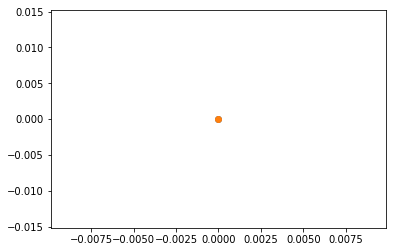

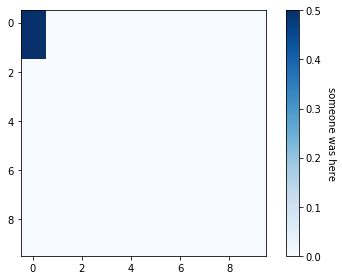

Current Random level is 0.7485007499999999
In Step 1000 the average reward in the last 1000 for the agents were:
Agent 0 : 0.0003796203796203796
Agent 1 : 0.0003996003996003996
2
range(0, 1001, 1000)
2
range(0, 1001, 1000)


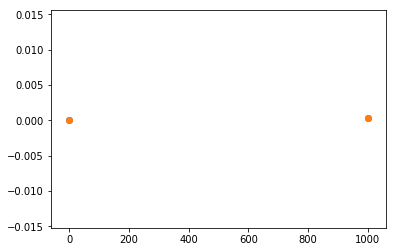

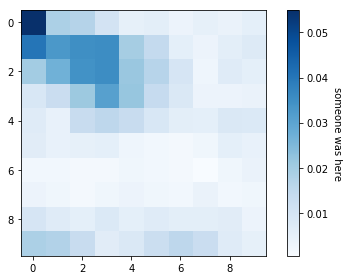

Current Random level is 0.74775224925
In Step 2000 the average reward in the last 1000 for the agents were:
Agent 0 : 0.0006196901549225388
Agent 1 : 0.0004997501249375312
3
range(0, 2001, 1000)
3
range(0, 2001, 1000)


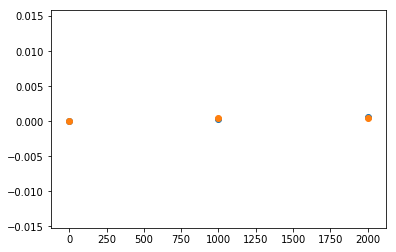

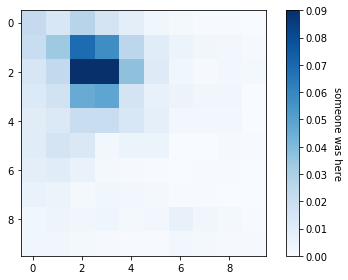

Current Random level is 0.7470044970007499
In Step 3000 the average reward in the last 1000 for the agents were:
Agent 0 : 0.0006097967344218593
Agent 1 : 0.0005431522825724758
4
range(0, 3001, 1000)
4
range(0, 3001, 1000)


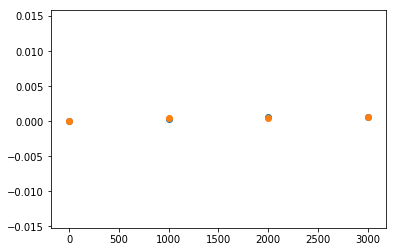

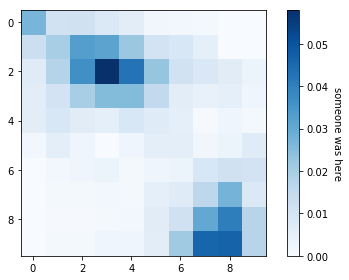

Current Random level is 0.7462574925037492
In Step 4000 the average reward in the last 1000 for the agents were:
Agent 0 : 0.0007173206698325419
Agent 1 : 0.0005773556610847288
5
range(0, 4001, 1000)
5
range(0, 4001, 1000)


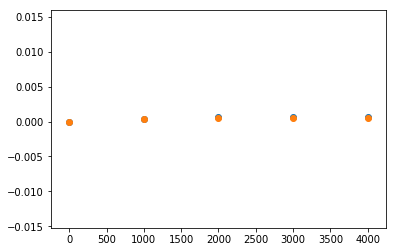

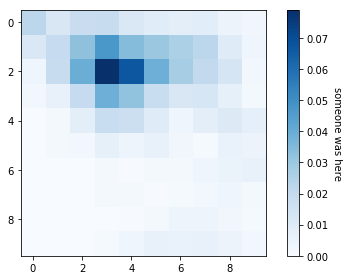

In [65]:
importlib.reload(E)
importlib.reload(H)
for i in range(config.n_episodes):
    env = E.Environment(dim = (config.grid_size_h,config.grid_size_w),reward_eat_trash=10, 
                        reward_invalid_move=0, reward_nothing_happend=0, 
                        trash_appearence_prob=0.1, number_trash_sources=0, saved_timesteps=config.time_steps )
    env.trash_sources.append(config.trash_source_1)# at [2,3]
    env.trash_sources.append(config.trash_source_2)# at [1,6]

    
    run(model,env)

#### Now reset the model, train it on a different environment and use the pretrained model to learn the environment on top again. Will it learn faster?

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 7, 7, 7)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 6, 6)          464       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 5, 5)          2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 2, 2)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 2, 2)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
__________

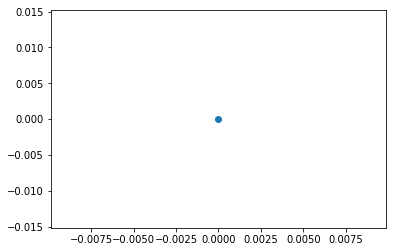

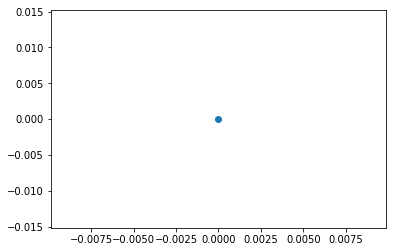

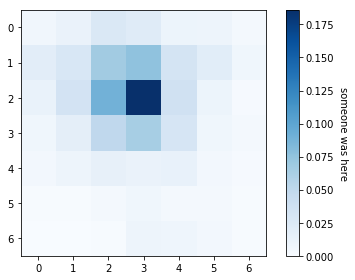

Current Random level is 0.726368306819645
In Step 1000 the average reward of 1000 is 0.16 
Actions: [211. 122. 244. 201. 222.]


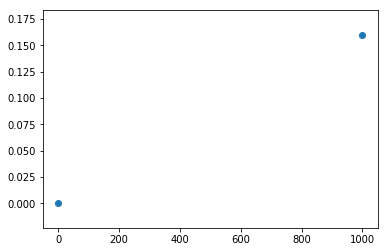

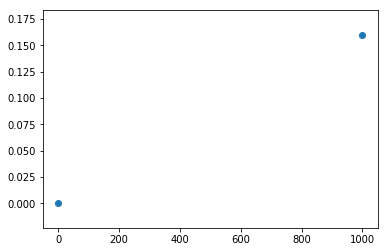

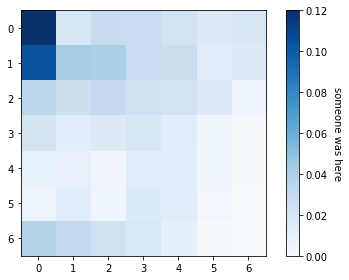

Current Random level is 0.7256419385128254
In Step 2000 the average reward of 1000 is 0.33 
Actions: [202. 121. 227. 227. 223.]


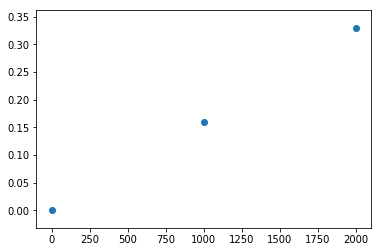

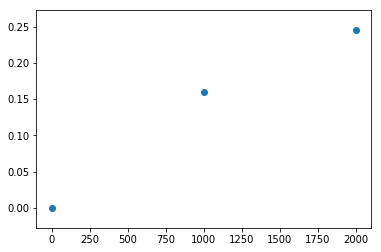

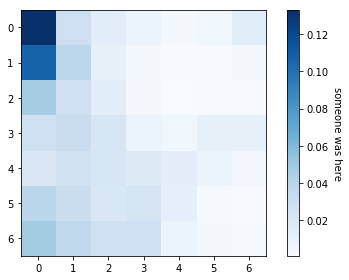

Current Random level is 0.7249162965743126
In Step 3000 the average reward of 1000 is 0.63 
Actions: [144. 190. 158. 310. 198.]


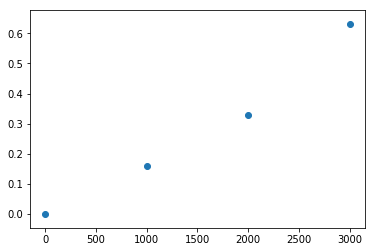

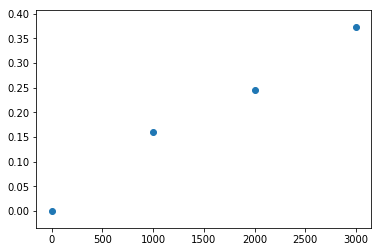

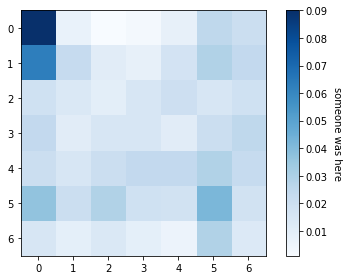

Current Random level is 0.7241913802777382
In Step 4000 the average reward of 1000 is 0.87 
Actions: [170. 196. 183. 231. 220.]


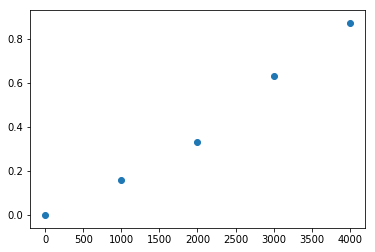

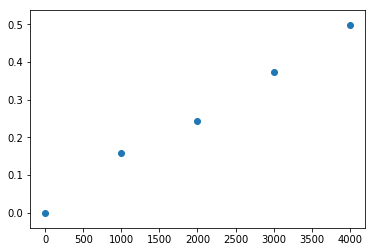

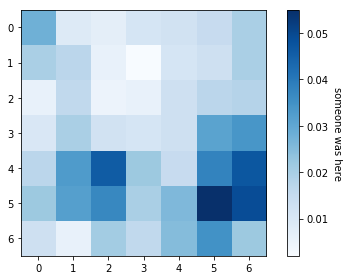

Current Random level is 0.7234671888974605
In Step 5000 the average reward of 1000 is 0.99 
Actions: [147. 212. 227. 252. 162.]


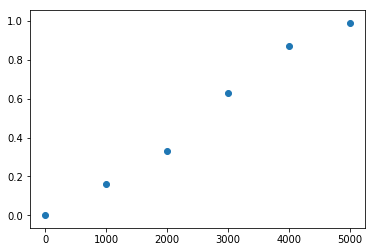

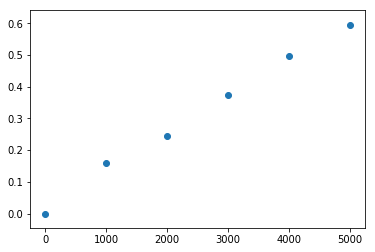

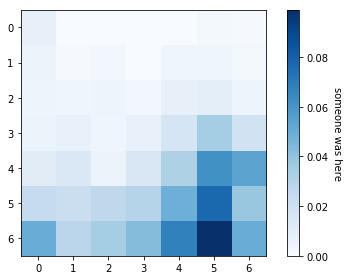

Current Random level is 0.722743721708563
In Step 6000 the average reward of 1000 is 1.24 
Actions: [170. 176. 224. 204. 226.]


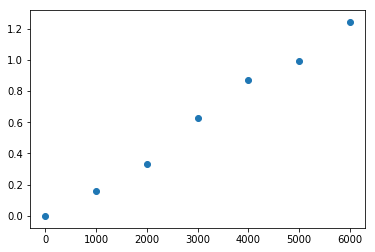

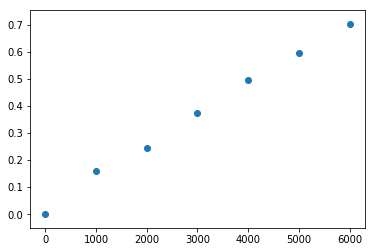

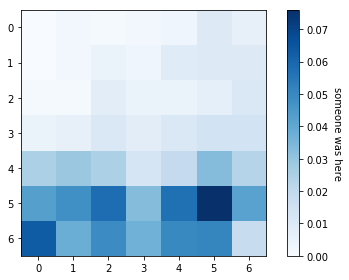

Current Random level is 0.7220209779868545
In Step 7000 the average reward of 1000 is 0.97 
Actions: [139. 186. 177. 209. 289.]


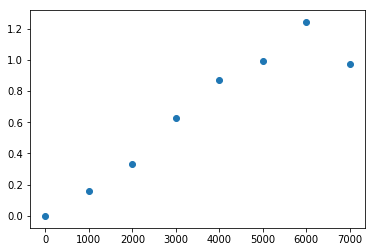

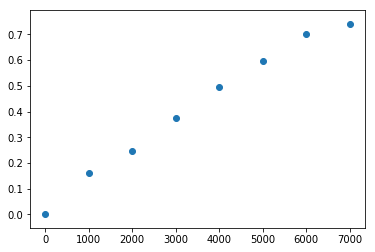

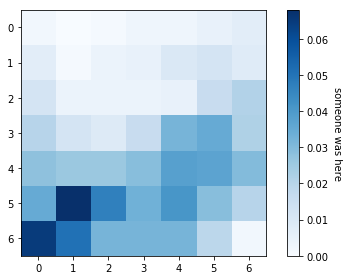

Current Random level is 0.7212989570088676
In Step 8000 the average reward of 1000 is 1.14 
Actions: [149. 118. 189. 157. 387.]


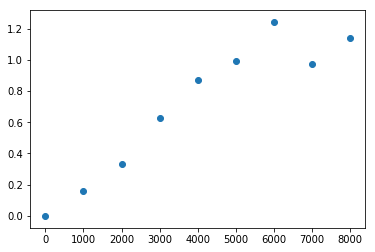

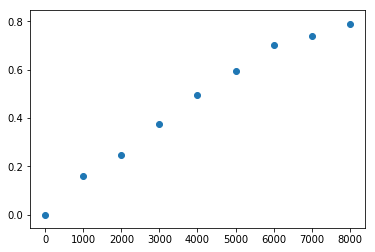

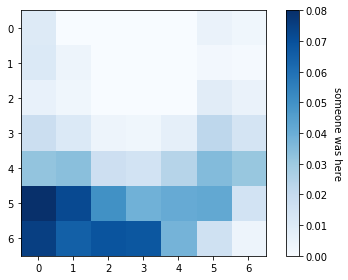

Current Random level is 0.7205776580518587
In Step 9000 the average reward of 1000 is 1.46 
Actions: [137. 118. 177. 165. 403.]


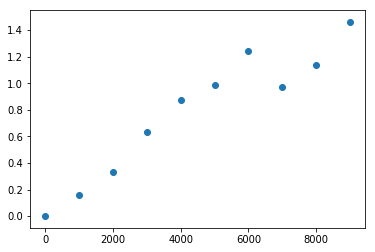

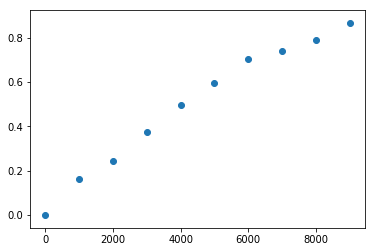

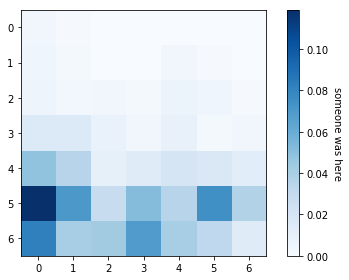

Current Random level is 0.7198570803938068
In Step 10000 the average reward of 1000 is 1.4 
Actions: [159. 123. 185. 165. 368.]


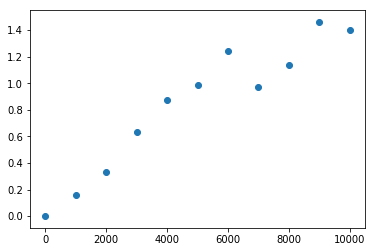

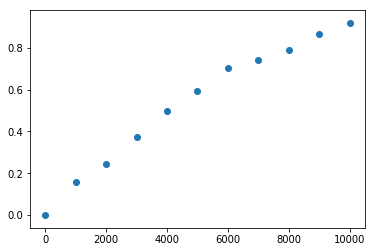

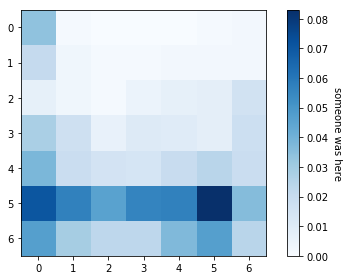

Current Random level is 0.719137223313413
In Step 11000 the average reward of 1000 is 1.09 
Actions: [155. 138. 206. 167. 334.]


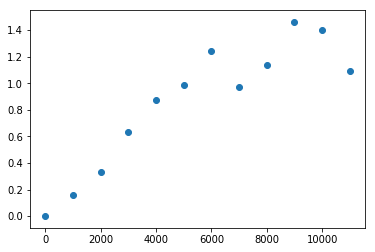

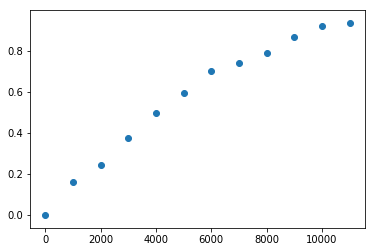

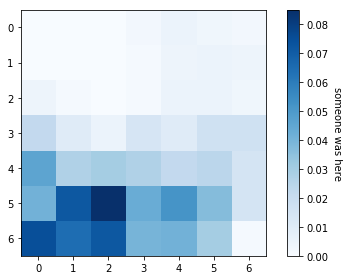

Current Random level is 0.7184180860900996
In Step 12000 the average reward of 1000 is 1.26 
Actions: [169. 174. 203. 194. 260.]


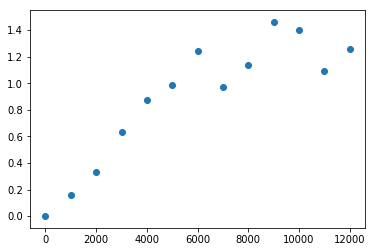

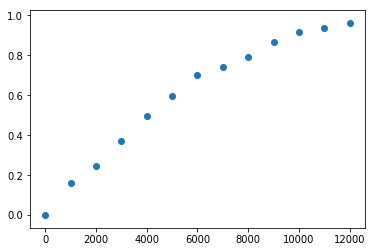

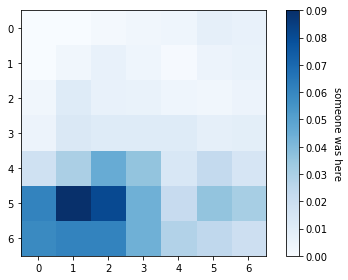

Current Random level is 0.7176996680040095
In Step 13000 the average reward of 1000 is 1.65 
Actions: [154. 184. 184. 205. 273.]


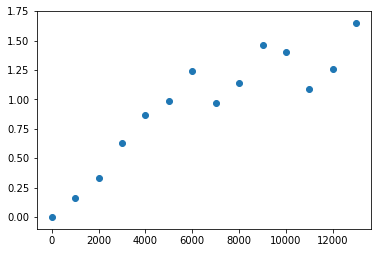

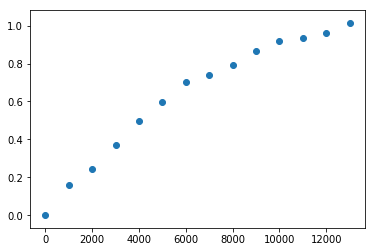

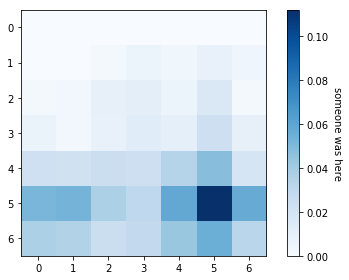

Current Random level is 0.7169819683360055
In Step 14000 the average reward of 1000 is 1.62 
Actions: [161. 173. 188. 220. 258.]


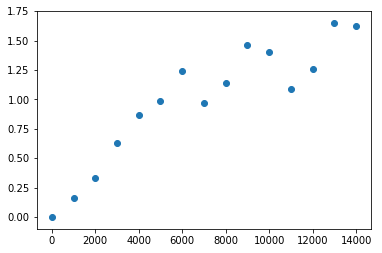

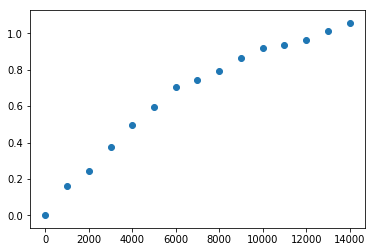

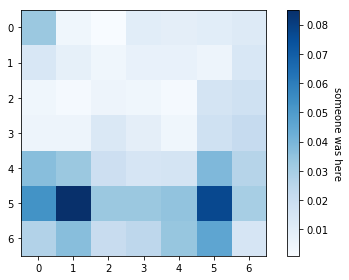

Current Random level is 0.7162649863676694
In Step 15000 the average reward of 1000 is 1.53 
Actions: [167. 172. 209. 210. 242.]


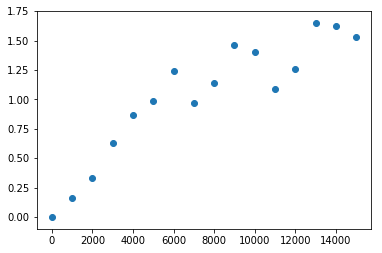

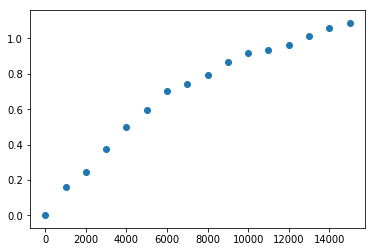

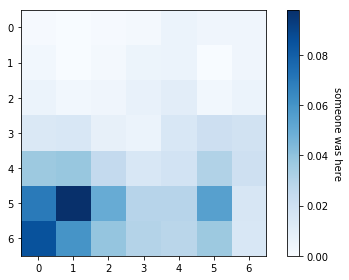

Current Random level is 0.7155487213813018
In Step 16000 the average reward of 1000 is 1.62 
Actions: [183. 168. 220. 190. 239.]


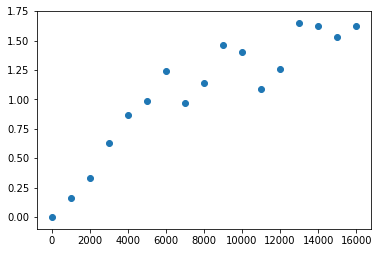

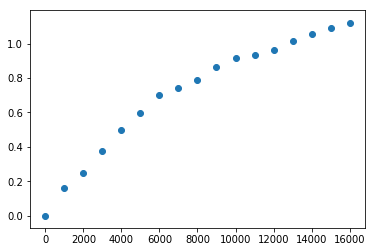

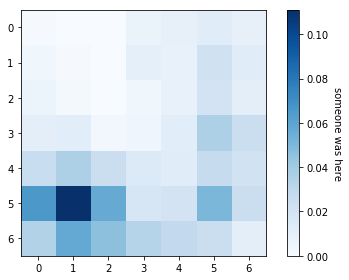

Current Random level is 0.7148331726599204
In Step 17000 the average reward of 1000 is 1.59 
Actions: [183. 164. 211. 212. 230.]


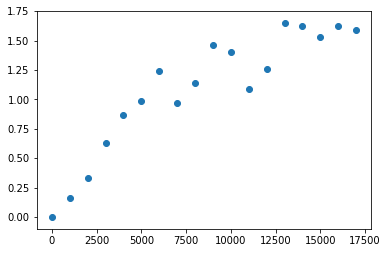

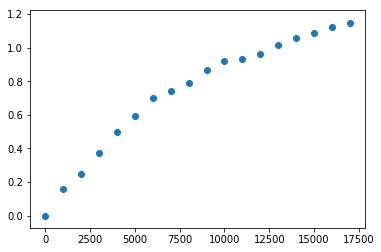

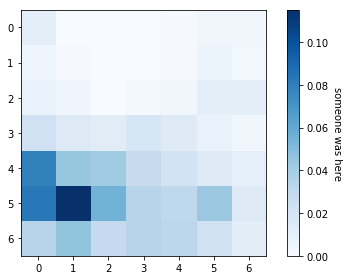

Current Random level is 0.7141183394872604
In Step 18000 the average reward of 1000 is 1.76 
Actions: [207. 153. 225. 203. 212.]


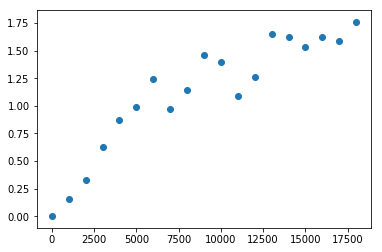

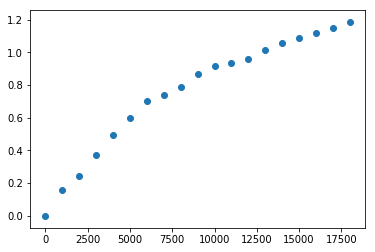

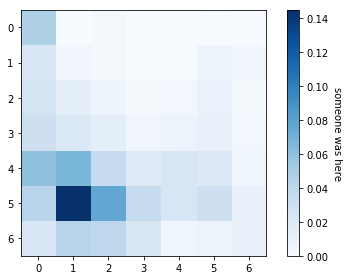

Current Random level is 0.7134042211477731
In Step 19000 the average reward of 1000 is 1.77 
Actions: [150. 189. 179. 211. 271.]


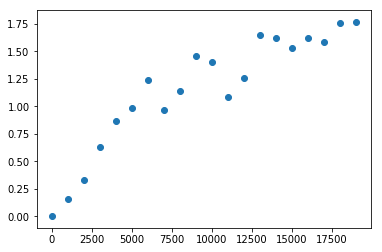

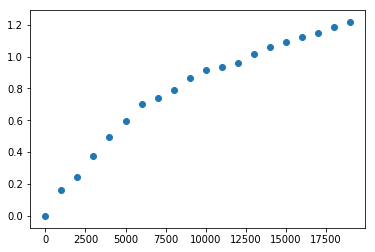

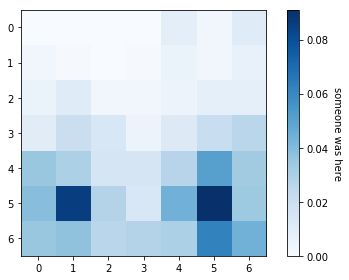

Current Random level is 0.7126908169266254
In Step 20000 the average reward of 1000 is 1.56 
Actions: [178. 162. 208. 211. 241.]


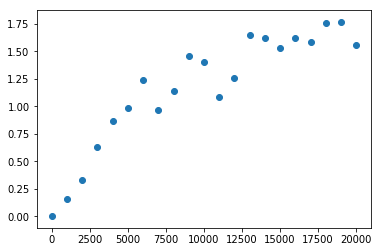

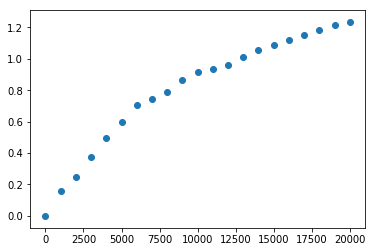

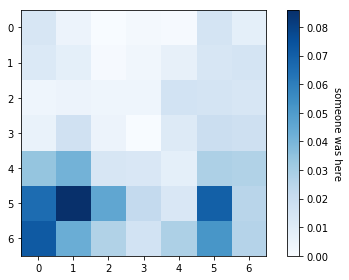

Current Random level is 0.7119781261096988
In Step 21000 the average reward of 1000 is 1.65 
Actions: [190. 172. 210. 182. 246.]


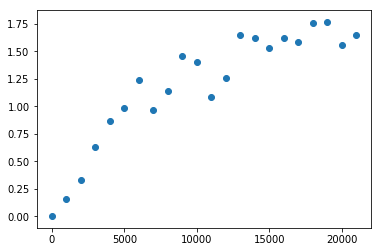

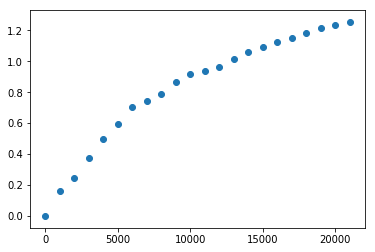

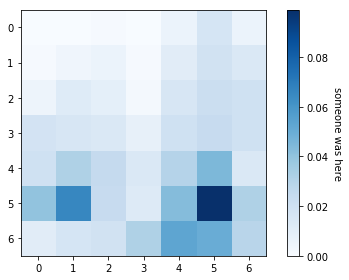

Current Random level is 0.7112661479835891
In Step 22000 the average reward of 1000 is 1.83 
Actions: [140. 180. 193. 211. 276.]


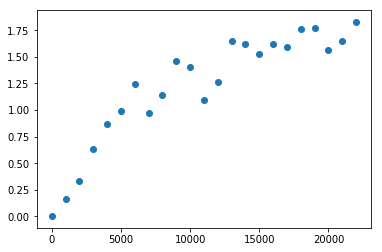

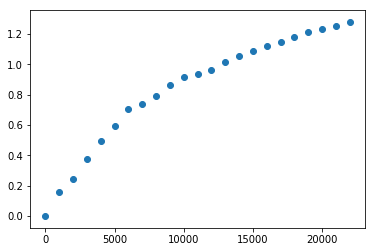

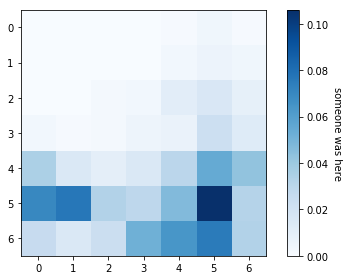

Current Random level is 0.7105548818356056
In Step 23000 the average reward of 1000 is 1.83 
Actions: [204. 167. 224. 203. 202.]


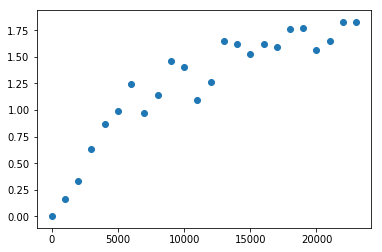

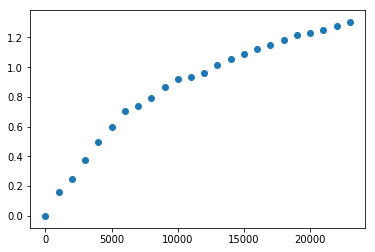

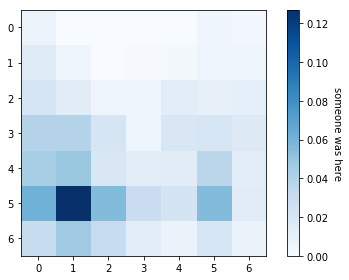

Current Random level is 0.70984432695377
In Step 24000 the average reward of 1000 is 2.16 
Actions: [195. 147. 217. 182. 259.]


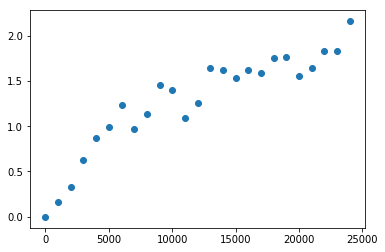

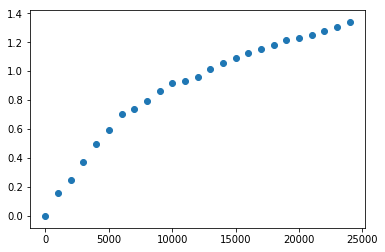

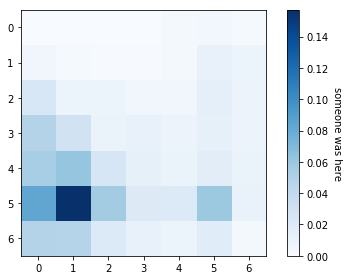

Current Random level is 0.7091344826268162
In Step 25000 the average reward of 1000 is 2.23 
Actions: [156. 186. 192. 226. 240.]


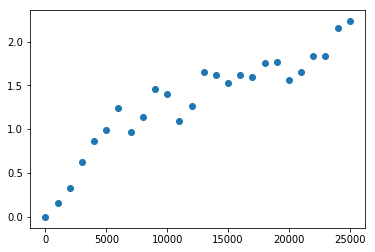

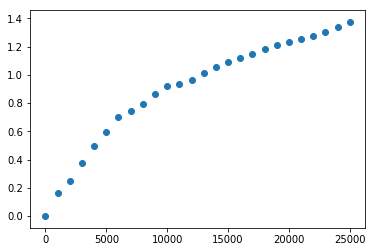

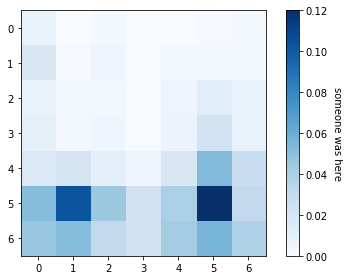

Current Random level is 0.7084253481441894
In Step 26000 the average reward of 1000 is 1.86 
Actions: [167. 185. 188. 224. 236.]


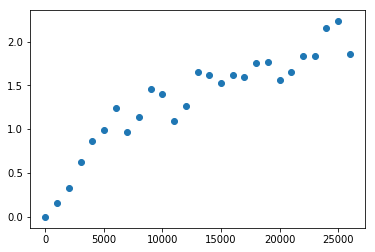

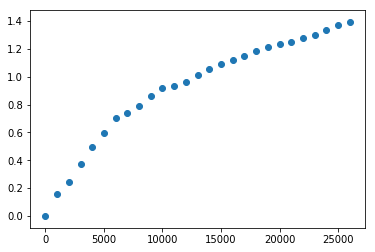

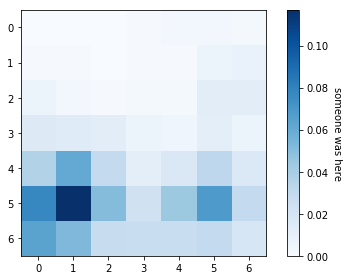

Current Random level is 0.7077169227960453
In Step 27000 the average reward of 1000 is 2.2 
Actions: [161. 174. 197. 214. 254.]


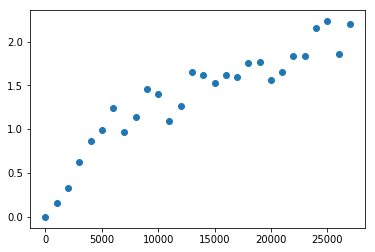

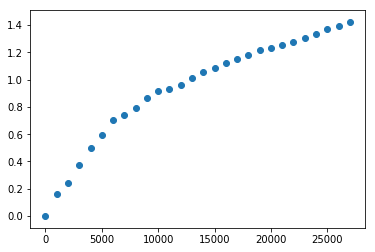

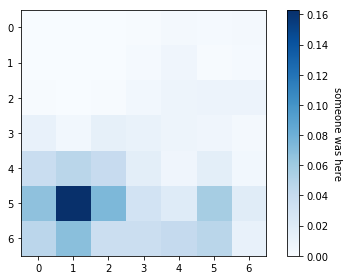

Current Random level is 0.7070092058732492
In Step 28000 the average reward of 1000 is 1.82 
Actions: [169. 166. 199. 214. 252.]


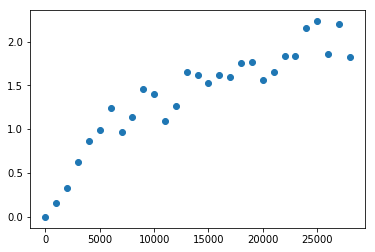

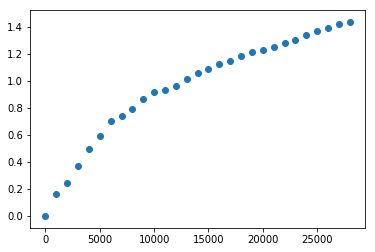

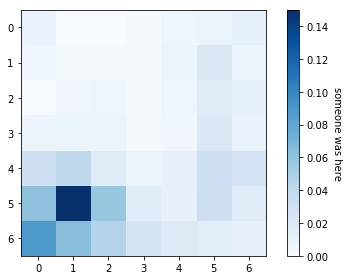

Current Random level is 0.7063021966673759
In Step 29000 the average reward of 1000 is 1.74 
Actions: [154. 188. 190. 222. 246.]


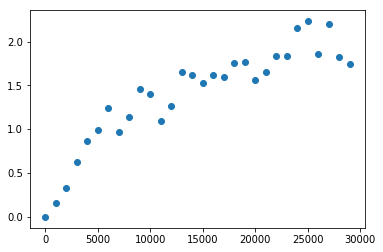

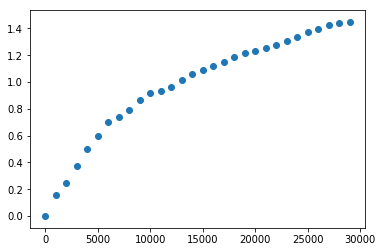

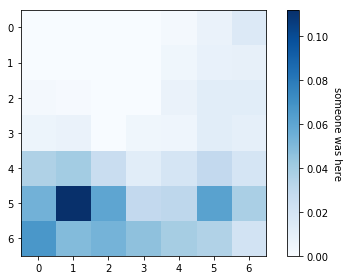

In [27]:
###########################################################################################
## Reset the model

data_i = Input(shape=(config.n_channels, config.grid_size_w, config.grid_size_h))
conv_1 = Conv2D(16, (2, 2), activation="relu", data_format="channels_first")(data_i)
conv_2 = Conv2D(32, (2, 2), activation="relu", data_format="channels_first")(conv_1)
pool_1 = MaxPooling2D(data_format="channels_first")(conv_2)
drop_1 = Dropout(0.25)(pool_1)
flat_1 = Flatten()(drop_1)
feed_1 = Dense(64, activation="relu")(flat_1)
drop_2 = Dropout(0.25)(feed_1)
feed_2 = Dense(config.n_actions, activation="linear")(drop_2)
data_o = feed_2

model = Model(inputs=data_i, outputs=data_o)

model.compile(optimizer="adam", loss="mse")

model.summary()


############################################################################################
## Set up a second environment
env2 = E.Environment(dim = (config.grid_size_h,config.grid_size_w),reward_eat_trash=10, 
                        reward_invalid_move=0, reward_nothing_happend=0, 
                        trash_appearence_prob=0.1, number_trash_sources=0, saved_timesteps=config.time_steps )
env2.trash_sources.append(config.trash_source_3)# at [5,1]
env2.trash_sources.append(config.trash_source_4)# at [5,5]
############################################################################################
## Run the model in the second environment
run(model, env2)

Trash Source 0 has its mean at [2, 3]
Trash Source 1 has its mean at [1, 6]
Episode 1 of 1
Current Random level is 0.7055958944707086
In Step 0 the average reward of 1000 is 0.0 
Actions: [0. 0. 0. 0. 1.]


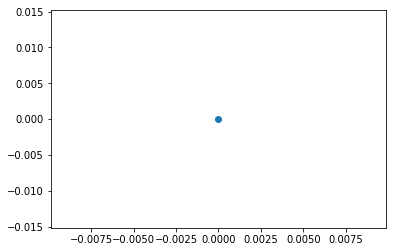

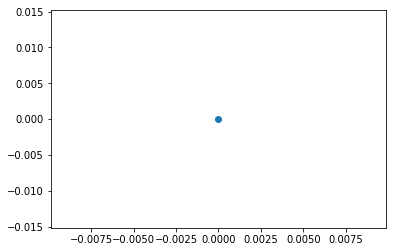

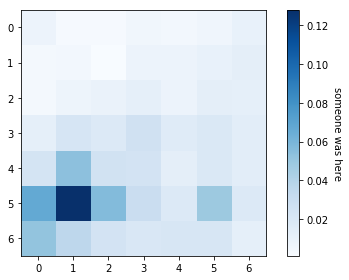

Current Random level is 0.7048902985762379
In Step 1000 the average reward of 1000 is 0.15 
Actions: [219. 186. 239. 198. 158.]


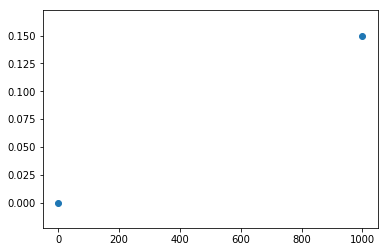

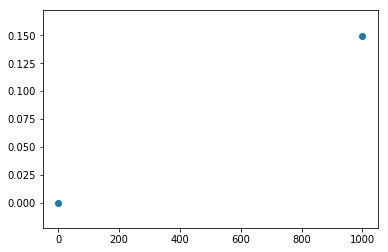

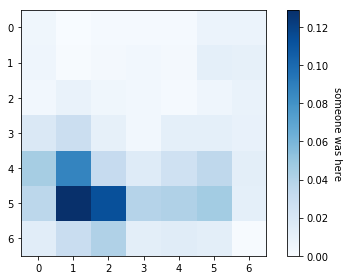

Current Random level is 0.7041854082776616
In Step 2000 the average reward of 1000 is 0.15 
Actions: [211. 189. 230. 199. 171.]


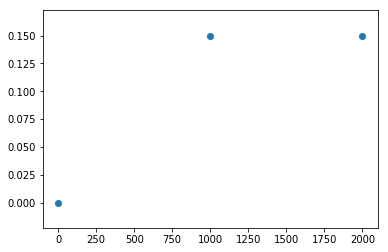

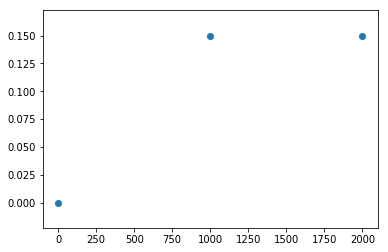

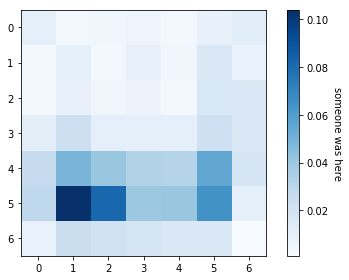

Current Random level is 0.703481222869384
In Step 3000 the average reward of 1000 is 0.34 
Actions: [218. 186. 225. 196. 175.]


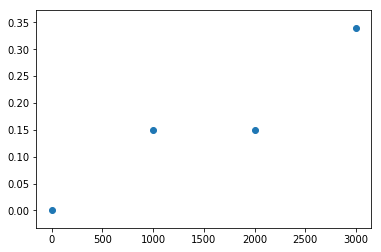

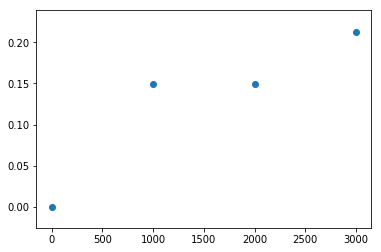

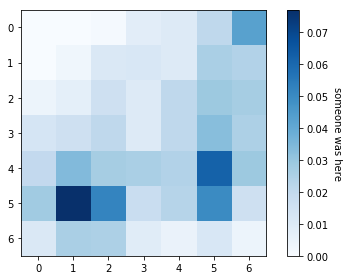

Current Random level is 0.7027777416465146
In Step 4000 the average reward of 1000 is 0.64 
Actions: [196. 166. 201. 186. 251.]


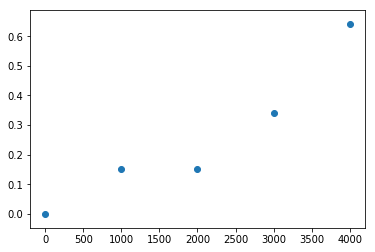

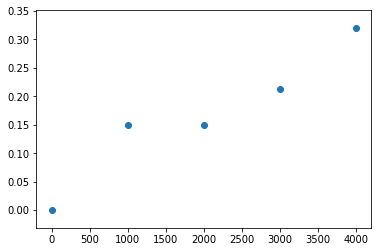

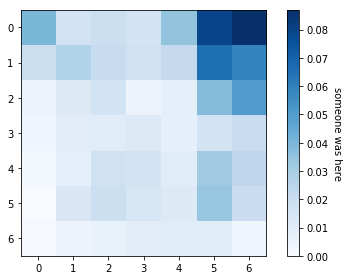

Current Random level is 0.7020749639048681
In Step 5000 the average reward of 1000 is 0.34 
Actions: [166. 167. 179. 202. 286.]


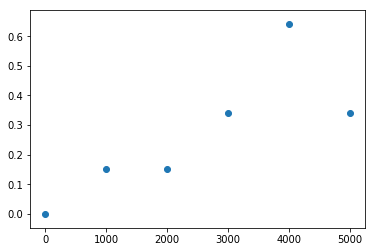

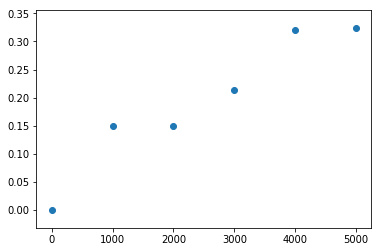

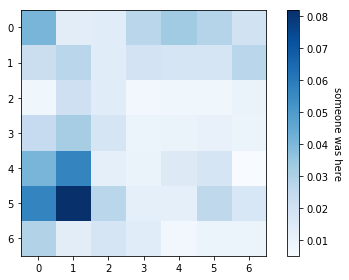

Current Random level is 0.7013728889409633
In Step 6000 the average reward of 1000 is 0.59 
Actions: [131. 158. 172. 179. 360.]


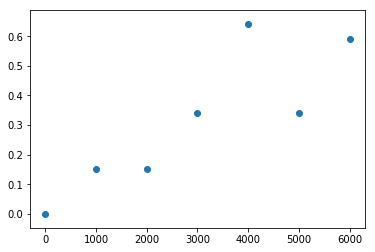

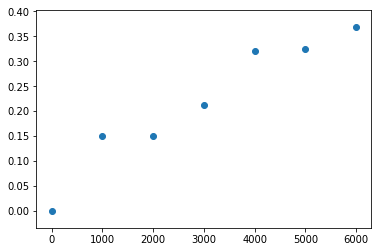

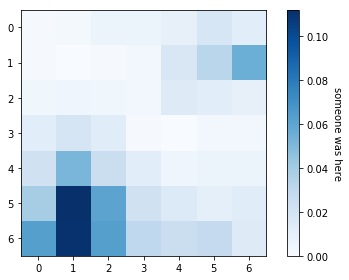

Current Random level is 0.7006715160520223
In Step 7000 the average reward of 1000 is 0.42 
Actions: [135. 169. 226. 197. 273.]


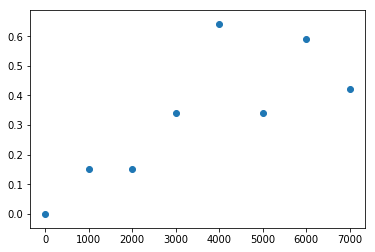

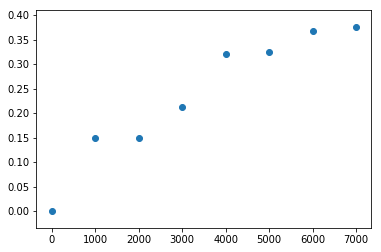

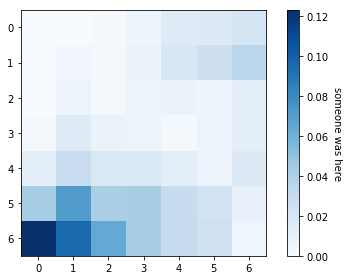

Current Random level is 0.6999708445359702
In Step 8000 the average reward of 1000 is 0.08 
Actions: [156. 170. 261. 175. 238.]


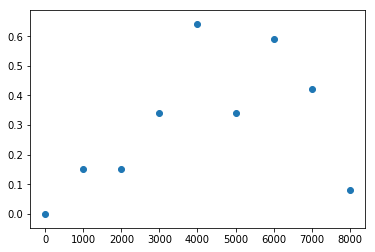

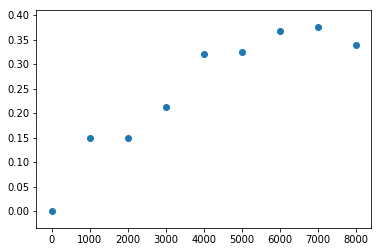

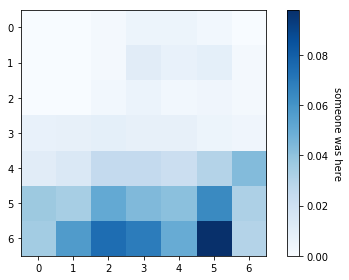

Current Random level is 0.6992708736914343
In Step 9000 the average reward of 1000 is 0.67 
Actions: [155. 174. 160. 236. 275.]


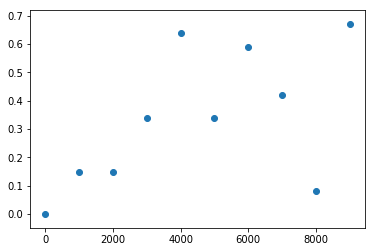

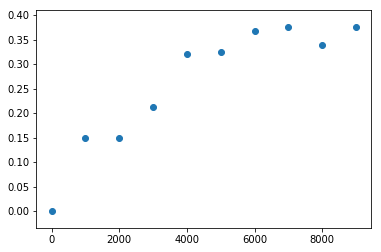

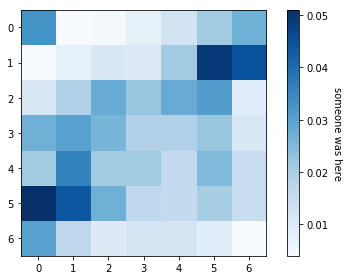

Current Random level is 0.6985716028177428
In Step 10000 the average reward of 1000 is 1.05 
Actions: [149. 143. 148. 227. 333.]


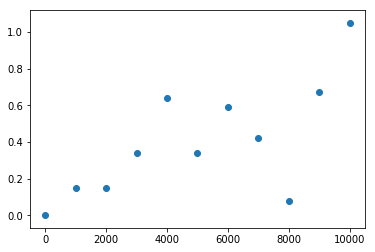

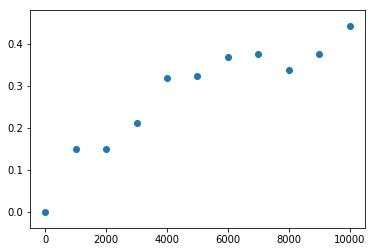

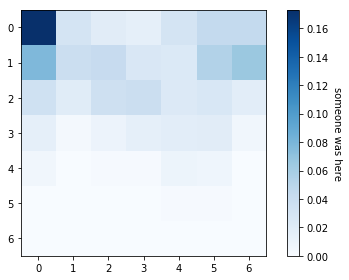

Current Random level is 0.697873031214925
In Step 11000 the average reward of 1000 is 1.94 
Actions: [106. 186. 112. 184. 412.]


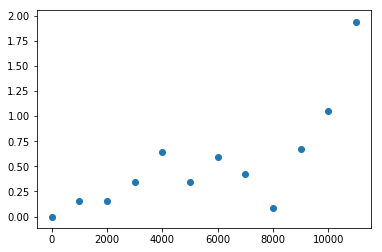

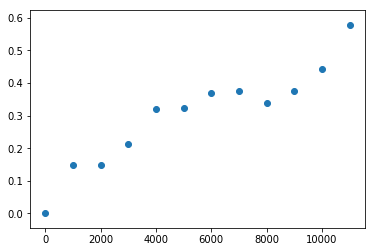

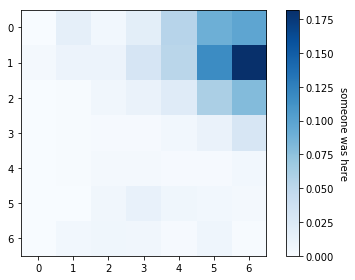

Current Random level is 0.6971751581837101
In Step 12000 the average reward of 1000 is 1.6 
Actions: [133. 178. 133. 178. 378.]


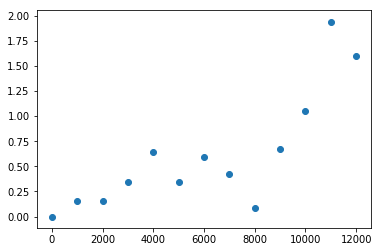

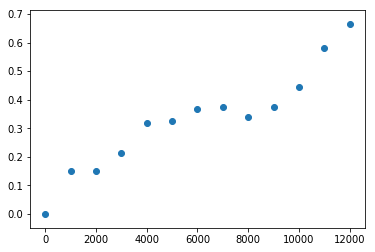

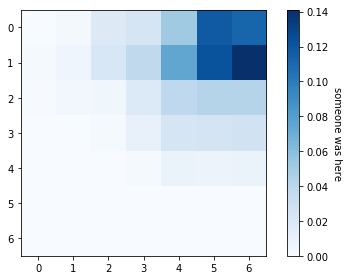

Current Random level is 0.6964779830255264
In Step 13000 the average reward of 1000 is 1.49 
Actions: [145. 186. 153. 197. 319.]


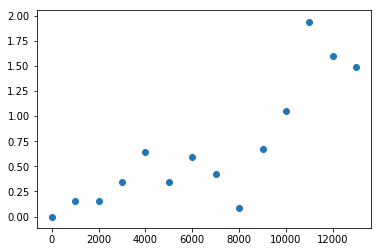

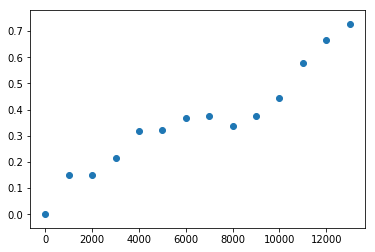

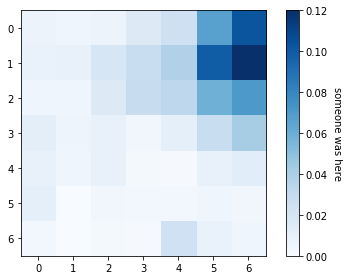

Current Random level is 0.6957815050425009
In Step 14000 the average reward of 1000 is 1.46 
Actions: [141. 173. 146. 176. 364.]


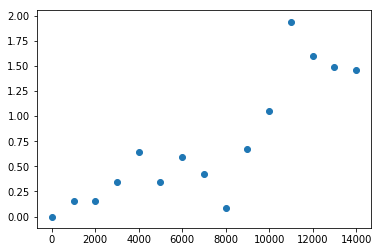

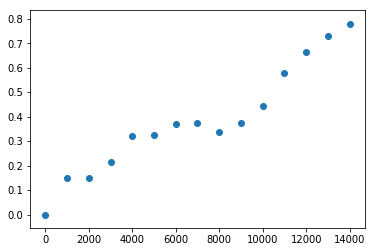

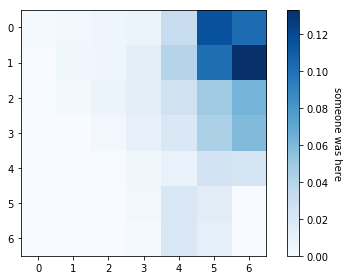

Current Random level is 0.6950857235374585
In Step 15000 the average reward of 1000 is 1.49 
Actions: [134. 203. 138. 202. 323.]


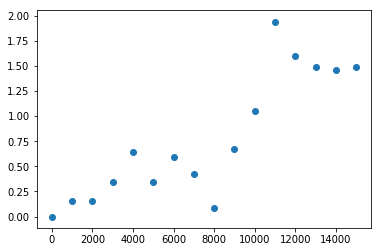

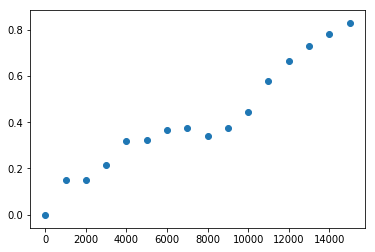

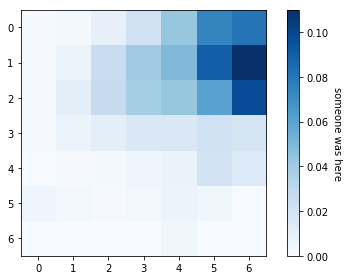

Current Random level is 0.694390637813921
In Step 16000 the average reward of 1000 is 1.74 
Actions: [130. 189. 133. 188. 360.]


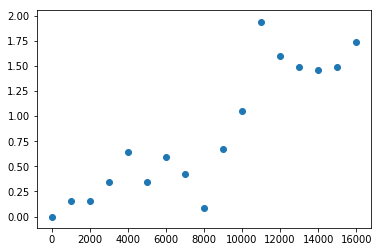

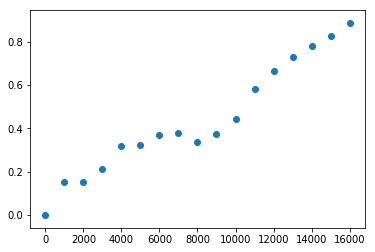

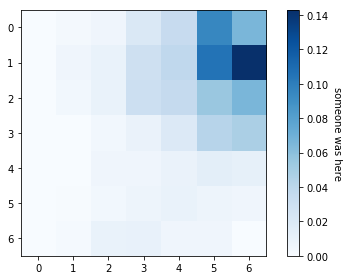

Current Random level is 0.693696247176107
In Step 17000 the average reward of 1000 is 1.51 
Actions: [127. 193. 132. 194. 354.]


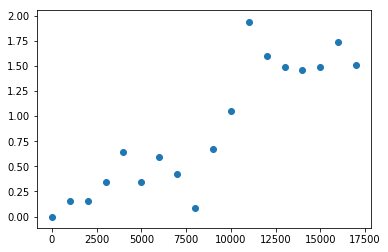

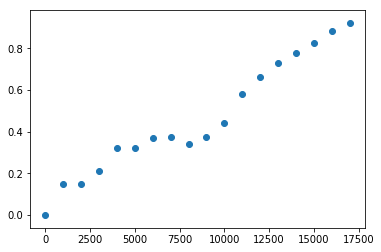

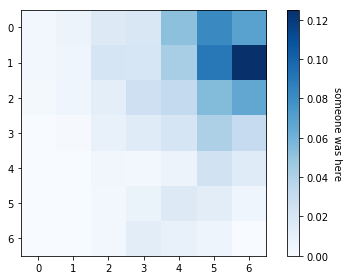

Current Random level is 0.6930025509289309
In Step 18000 the average reward of 1000 is 1.59 
Actions: [119. 188. 125. 194. 374.]


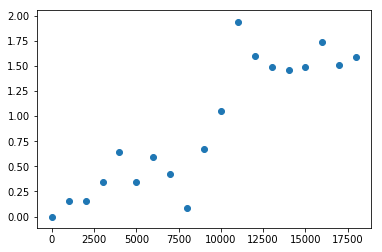

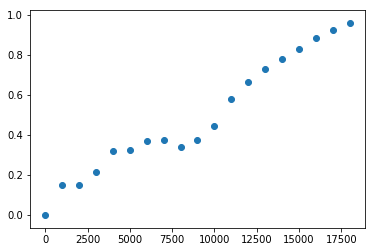

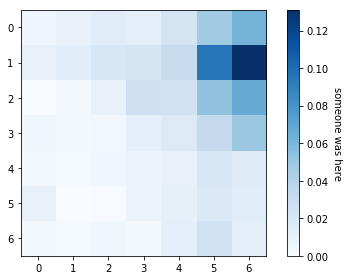

Current Random level is 0.692309548378002
In Step 19000 the average reward of 1000 is 1.76 
Actions: [127. 195. 128. 201. 349.]


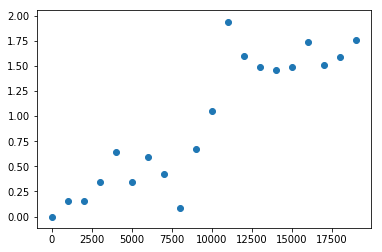

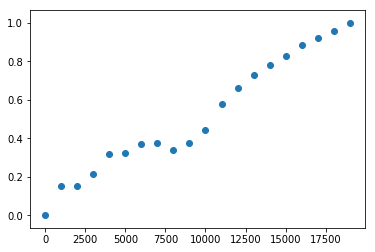

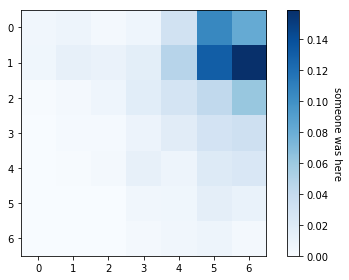

Current Random level is 0.691617238829624
In Step 20000 the average reward of 1000 is 1.96 
Actions: [118. 208. 115. 215. 344.]


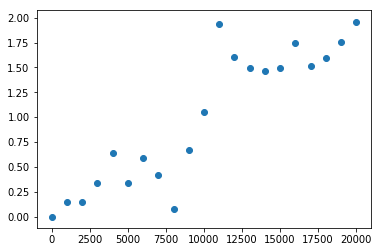

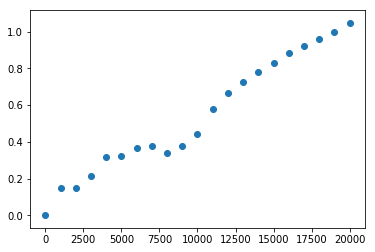

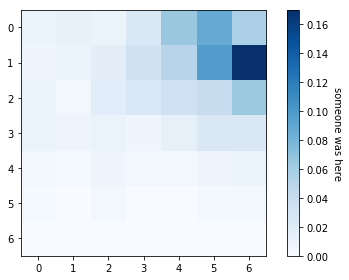

Current Random level is 0.6909256215907944
In Step 21000 the average reward of 1000 is 1.51 
Actions: [120. 186. 120. 188. 386.]


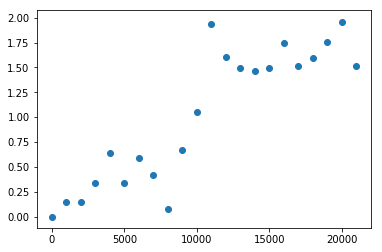

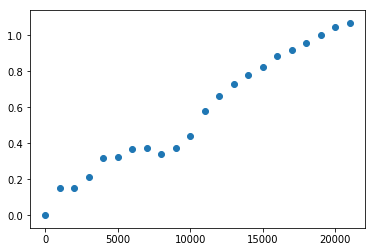

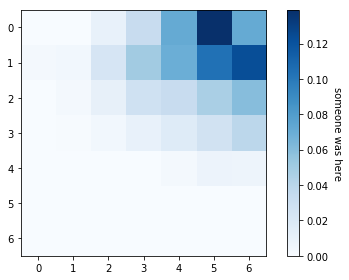

Current Random level is 0.6902346959692036
In Step 22000 the average reward of 1000 is 1.52 
Actions: [127. 191. 128. 190. 364.]


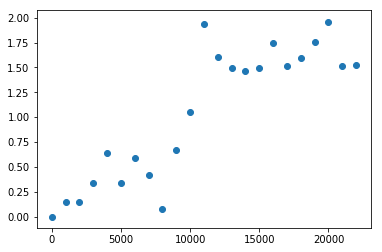

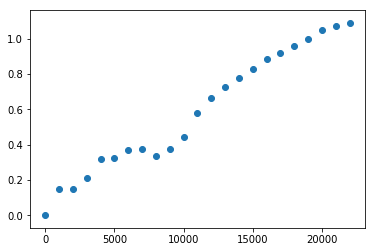

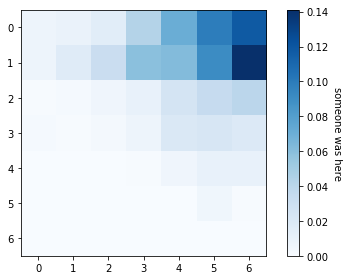

Current Random level is 0.6895444612732344
In Step 23000 the average reward of 1000 is 1.25 
Actions: [131. 196. 135. 196. 342.]


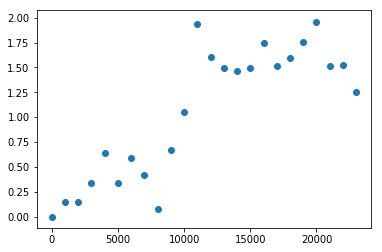

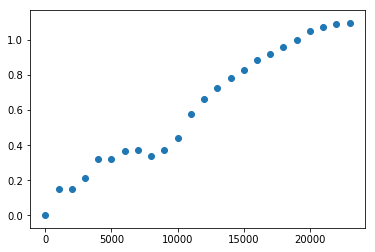

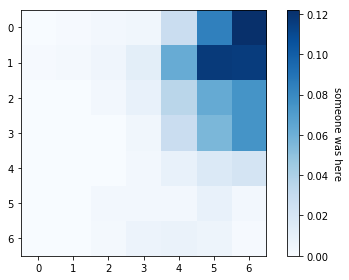

Current Random level is 0.6888549168119612
In Step 24000 the average reward of 1000 is 1.73 
Actions: [120. 216. 120. 220. 324.]


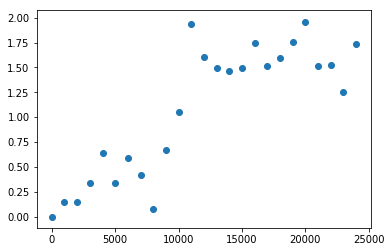

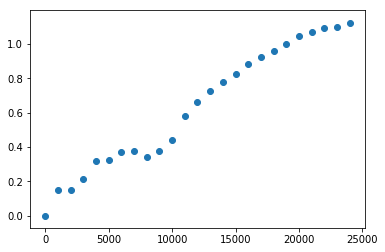

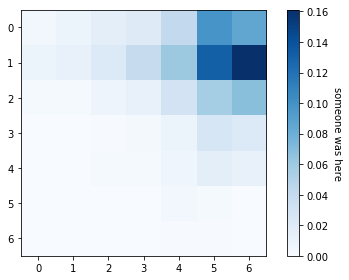

Current Random level is 0.6881660618951493
In Step 25000 the average reward of 1000 is 1.23 
Actions: [125. 178. 128. 183. 386.]


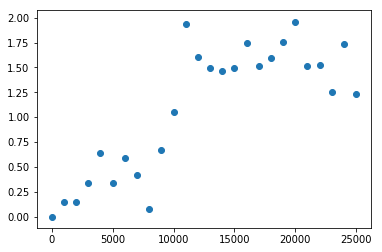

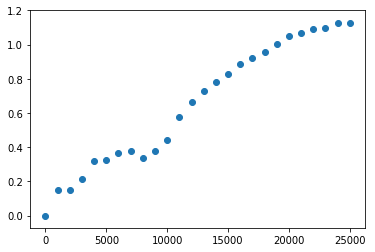

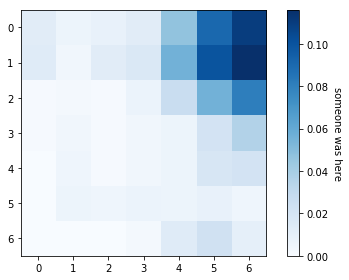

Current Random level is 0.6874778958332541
In Step 26000 the average reward of 1000 is 1.51 
Actions: [120. 199. 131. 200. 350.]


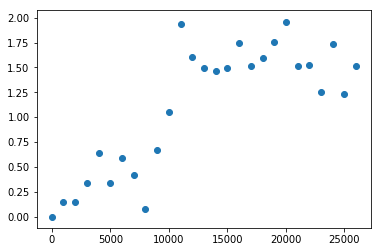

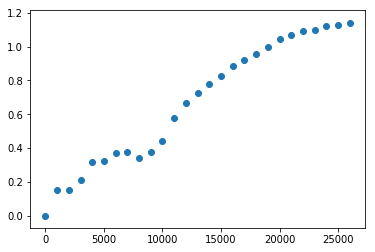

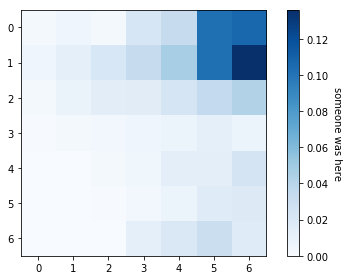

Current Random level is 0.6867904179374209
In Step 27000 the average reward of 1000 is 1.5 
Actions: [121. 216. 124. 219. 320.]


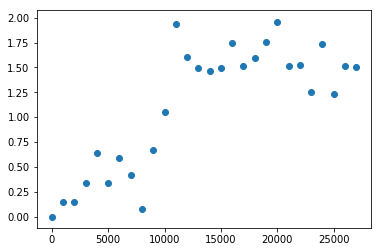

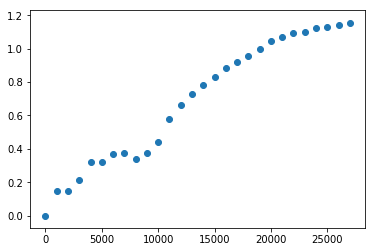

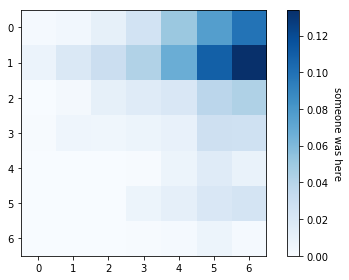

Current Random level is 0.6861036275194835
In Step 28000 the average reward of 1000 is 1.47 
Actions: [133. 202. 138. 203. 324.]


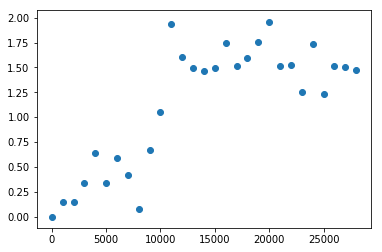

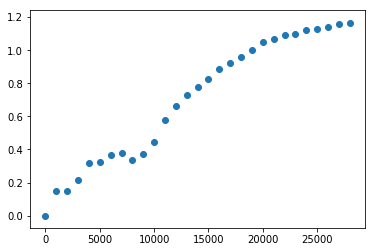

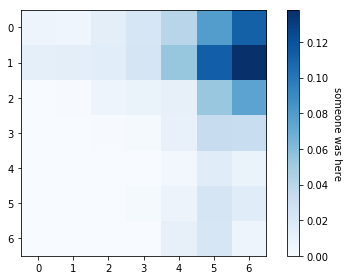

Current Random level is 0.685417523891964
In Step 29000 the average reward of 1000 is 1.16 
Actions: [129. 194. 130. 194. 353.]


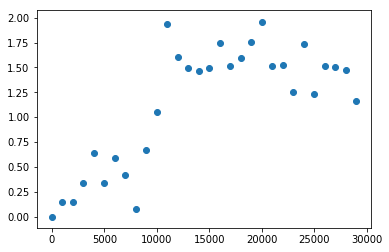

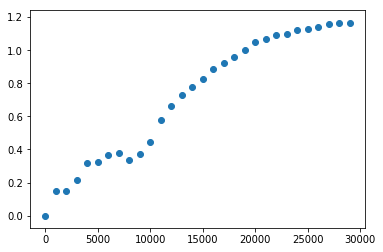

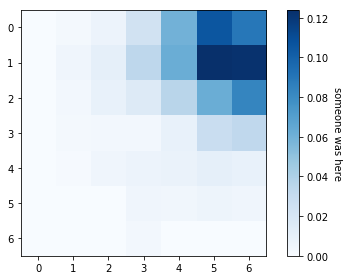

In [29]:
###########################################################################################
## Run the pretrained model again on the old environment
env = E.Environment(dim = (config.grid_size_h,config.grid_size_w),reward_eat_trash=10, 
                        reward_invalid_move=0, reward_nothing_happend=0, 
                        trash_appearence_prob=0.1, number_trash_sources=0, saved_timesteps=config.time_steps )
env.trash_sources.append(config.trash_source_1)# at [2,3]
env.trash_sources.append(config.trash_source_2)# at [1,6]

run(model, env)

Trash Source 0 has its mean at [1, 5]
Trash Source 1 has its mean at [4, 2]
Episode 1 of 1
Current Random level is 0.74925
In Step 0 the average reward of 1000 is 0.0 
Actions: [0. 0. 0. 0. 1.]


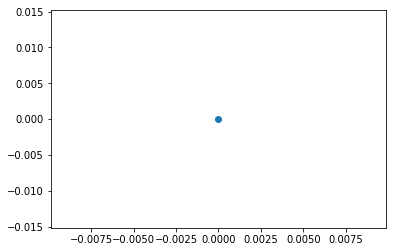

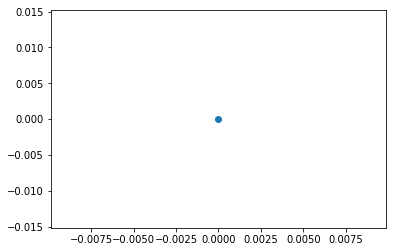

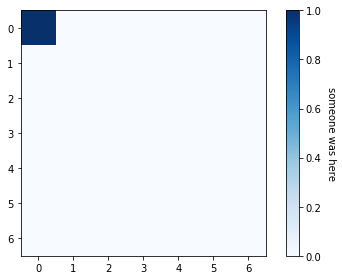

Current Random level is 0.7485007499999999
In Step 1000 the average reward of 1000 is 0.32 
Actions: [161. 160. 241. 217. 221.]


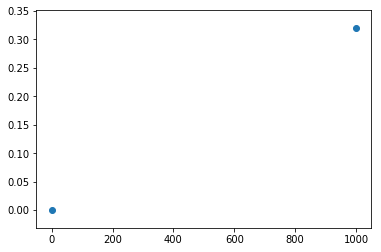

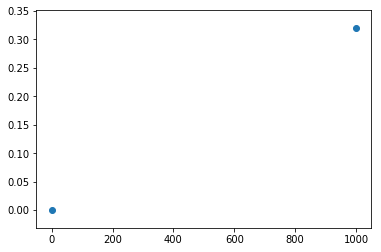

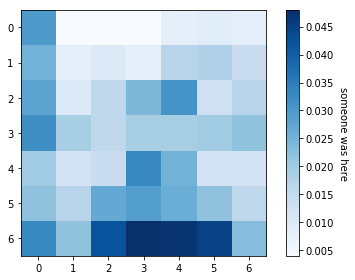

Current Random level is 0.74775224925
In Step 2000 the average reward of 1000 is 0.24 
Actions: [195. 124. 231. 223. 227.]


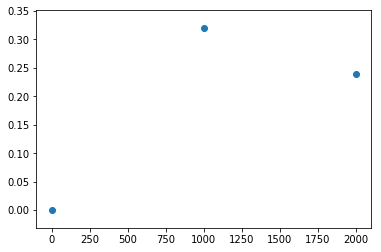

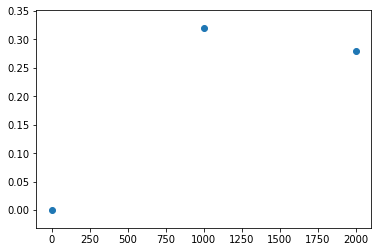

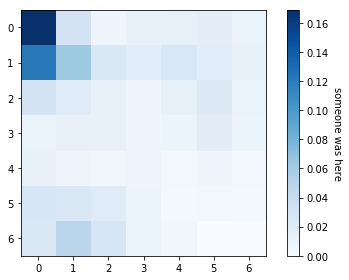

Current Random level is 0.7470044970007499
In Step 3000 the average reward of 1000 is 0.18 
Actions: [217. 103. 221. 281. 178.]


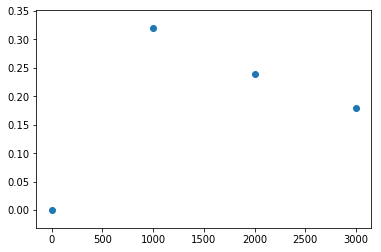

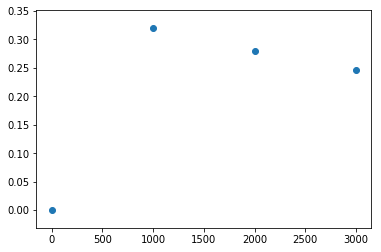

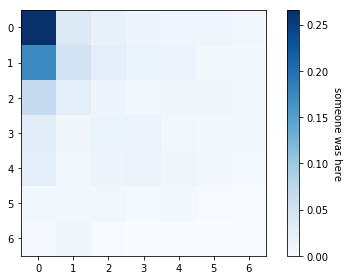

Current Random level is 0.7462574925037492
In Step 4000 the average reward of 1000 is 0.64 
Actions: [167. 147. 179. 180. 327.]


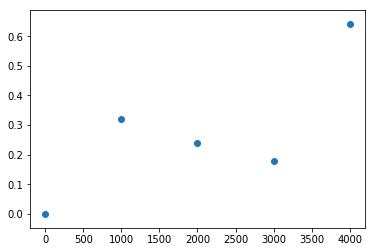

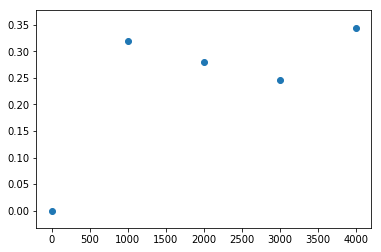

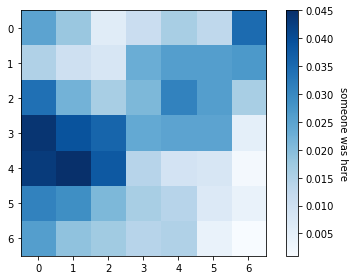

Current Random level is 0.7455112350112454
In Step 5000 the average reward of 1000 is 0.69 
Actions: [163. 151. 222. 173. 291.]


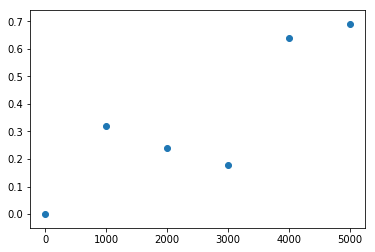

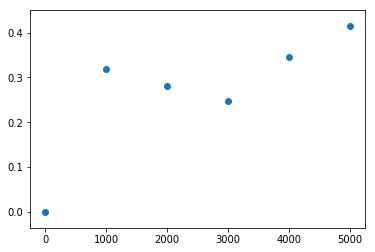

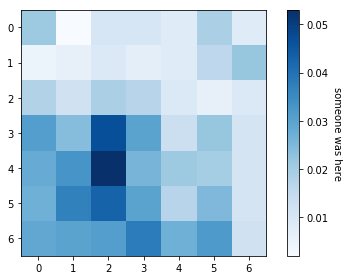

Current Random level is 0.7447657237762342
In Step 6000 the average reward of 1000 is 1.24 
Actions: [178. 189. 204. 218. 211.]


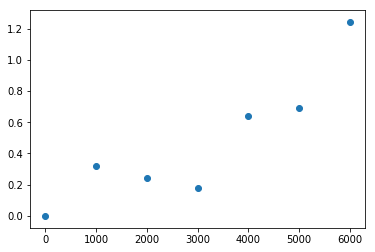

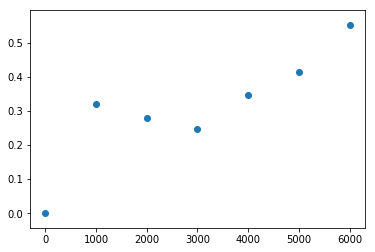

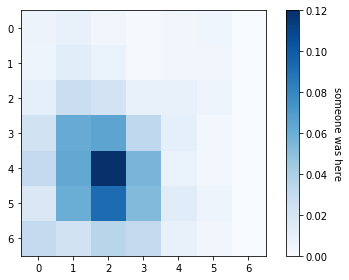

Current Random level is 0.7440209580524579
In Step 7000 the average reward of 1000 is 1.48 
Actions: [174. 189. 186. 215. 236.]


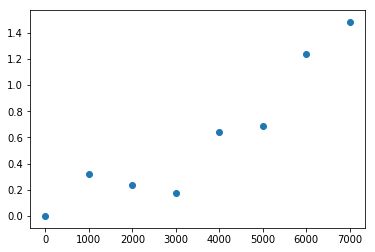

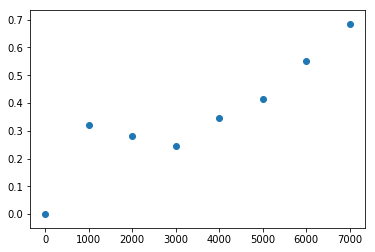

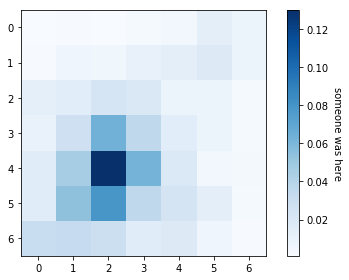

Current Random level is 0.7432769370944055
In Step 8000 the average reward of 1000 is 1.38 
Actions: [203. 189. 217. 200. 191.]


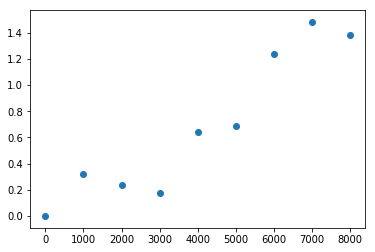

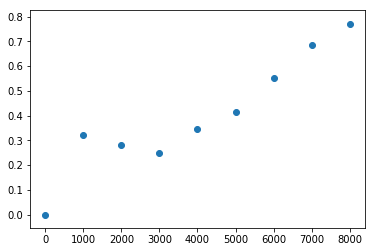

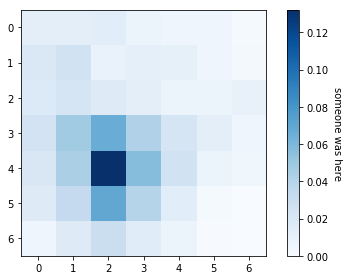

Current Random level is 0.742533660157311
In Step 9000 the average reward of 1000 is 1.76 
Actions: [193. 199. 206. 216. 186.]


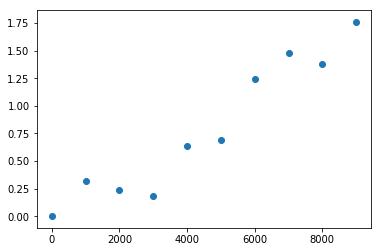

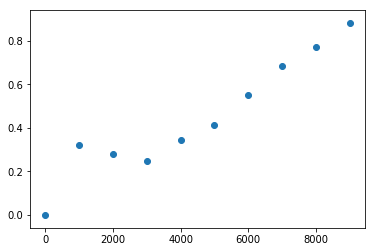

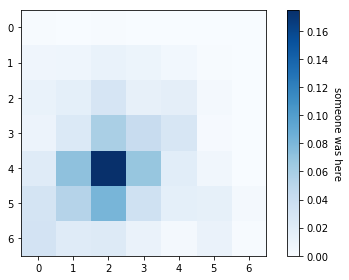

Current Random level is 0.7417911264971537
In Step 10000 the average reward of 1000 is 2.18 
Actions: [195. 192. 198. 202. 213.]


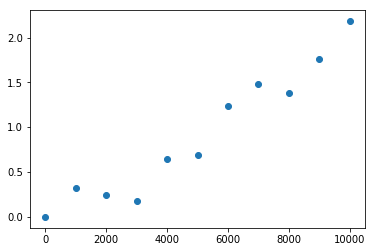

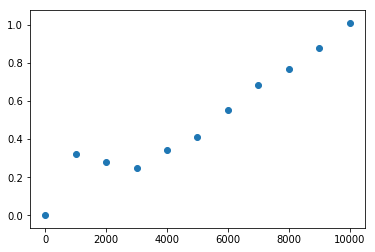

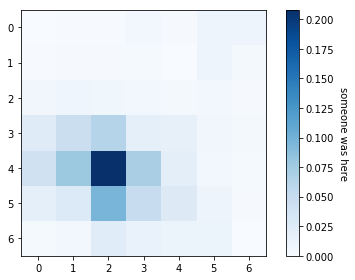

Current Random level is 0.7410493353706565
In Step 11000 the average reward of 1000 is 1.76 
Actions: [199. 177. 215. 196. 213.]


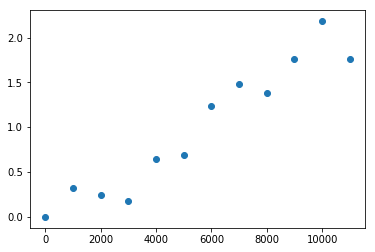

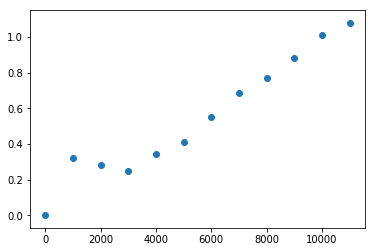

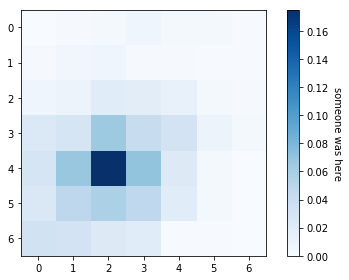

Current Random level is 0.7403082860352859
In Step 12000 the average reward of 1000 is 1.28 
Actions: [174. 197. 182. 218. 229.]


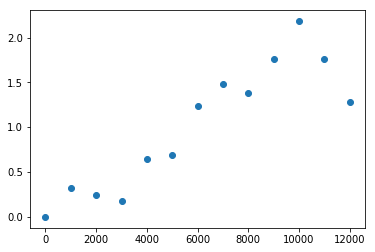

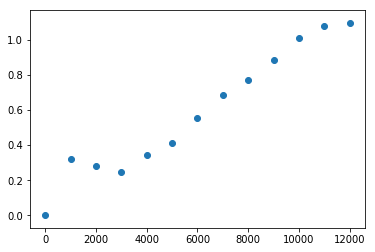

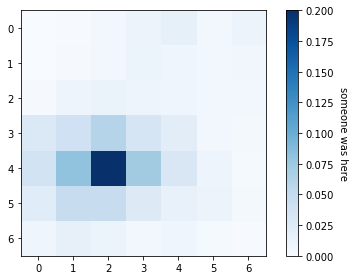

Current Random level is 0.7395679777492505
In Step 13000 the average reward of 1000 is 1.14 
Actions: [207. 180. 220. 193. 200.]


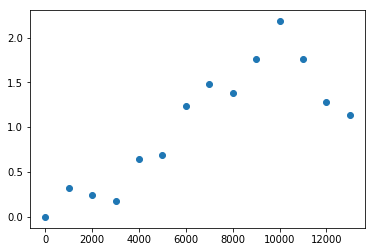

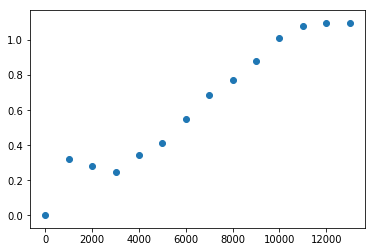

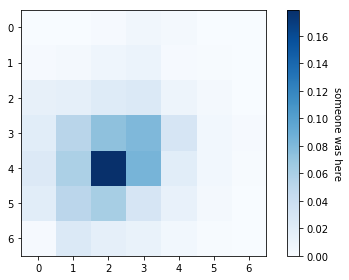

Current Random level is 0.7388284097715013
In Step 14000 the average reward of 1000 is 1.09 
Actions: [221. 179. 234. 187. 179.]


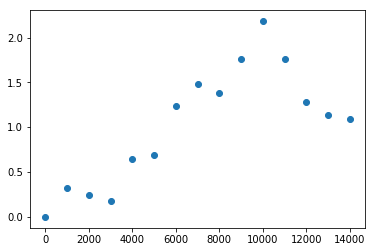

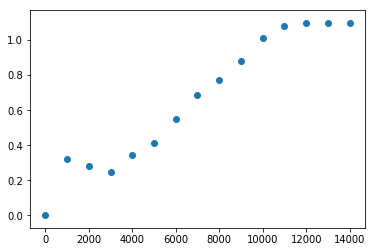

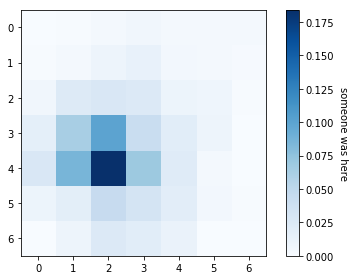

Current Random level is 0.7380895813617299
In Step 15000 the average reward of 1000 is 1.3 
Actions: [184. 203. 204. 215. 194.]


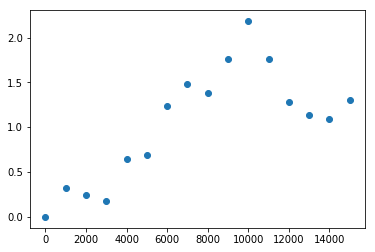

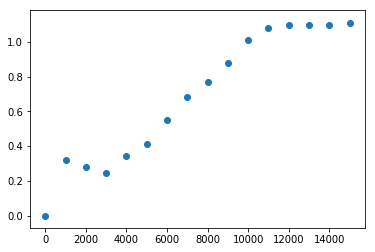

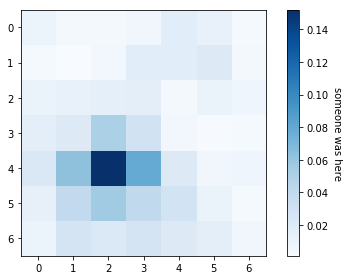

Current Random level is 0.7373514917803682
In Step 16000 the average reward of 1000 is 1.13 
Actions: [217. 183. 220. 203. 177.]


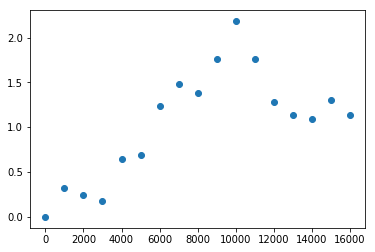

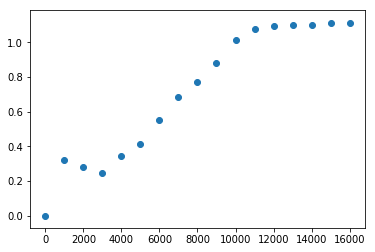

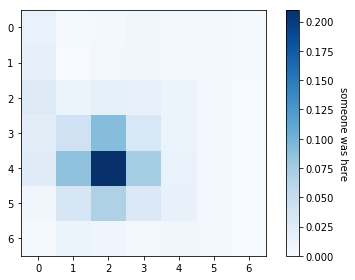

Current Random level is 0.7366141402885878
In Step 17000 the average reward of 1000 is 1.11 
Actions: [194. 165. 199. 187. 255.]


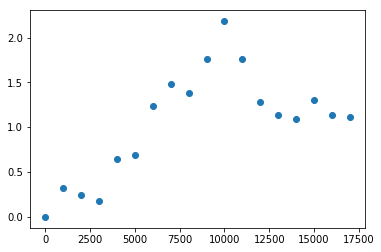

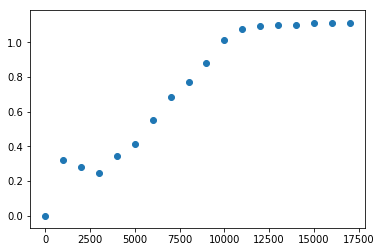

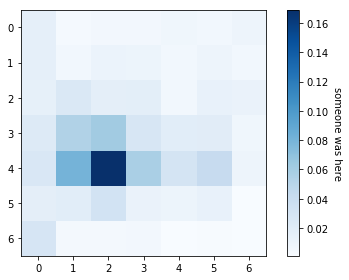

Current Random level is 0.7358775261482993
In Step 18000 the average reward of 1000 is 1.12 
Actions: [223. 161. 230. 175. 211.]


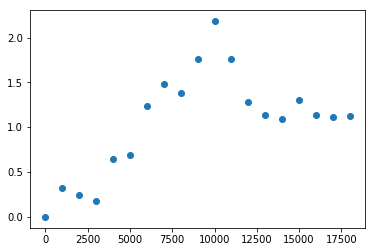

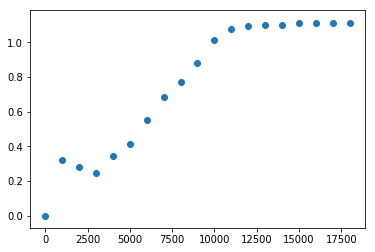

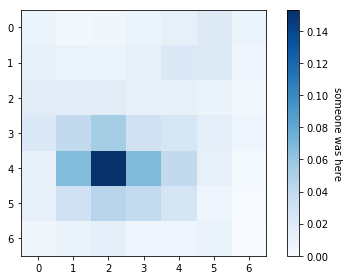

Current Random level is 0.7351416486221509
In Step 19000 the average reward of 1000 is 1.21 
Actions: [191. 171. 205. 203. 230.]


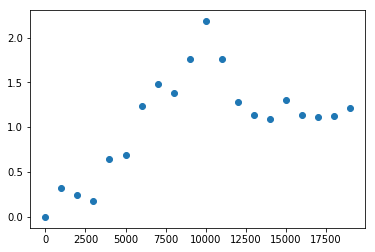

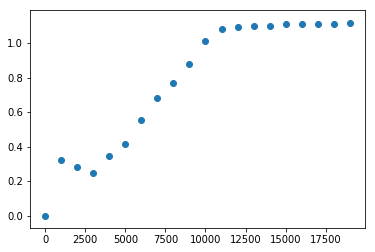

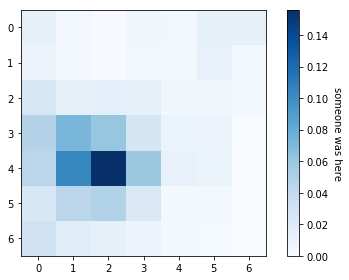

Current Random level is 0.7344065069735287
In Step 20000 the average reward of 1000 is 0.91 
Actions: [228. 183. 236. 206. 147.]


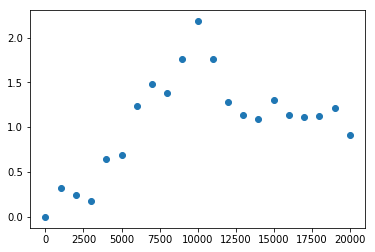

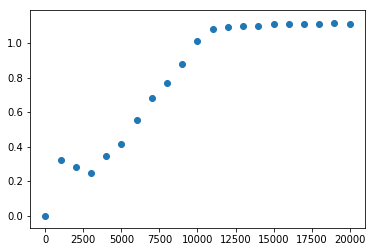

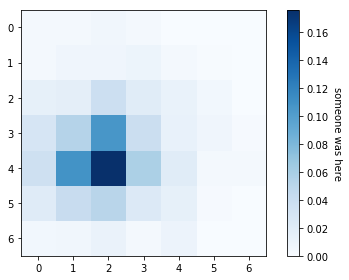

Current Random level is 0.7336721004665552
In Step 21000 the average reward of 1000 is 1.12 
Actions: [209. 174. 213. 183. 221.]


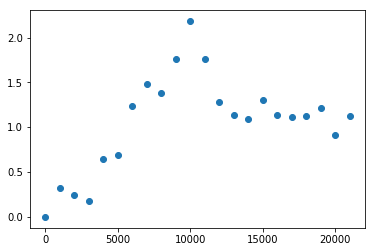

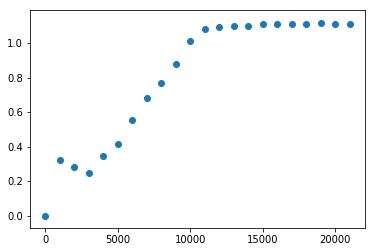

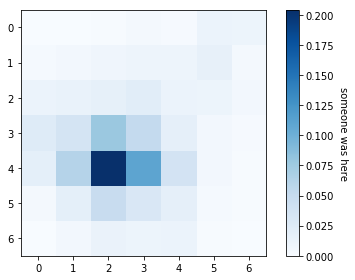

Current Random level is 0.7329384283660886
In Step 22000 the average reward of 1000 is 1.1 
Actions: [201. 189. 205. 203. 202.]


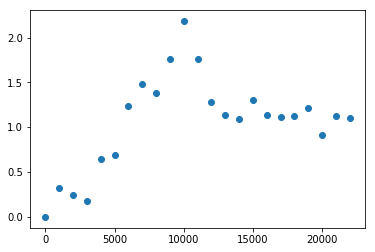

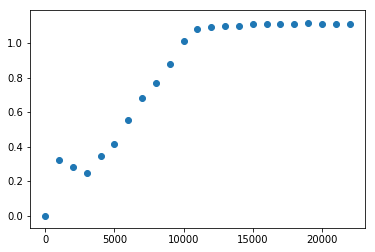

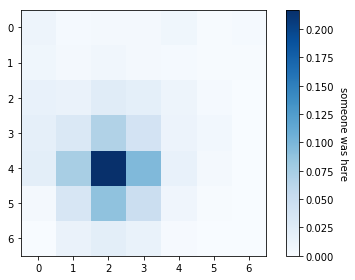

Current Random level is 0.7322054899377225
In Step 23000 the average reward of 1000 is 1.34 
Actions: [230. 161. 241. 177. 191.]


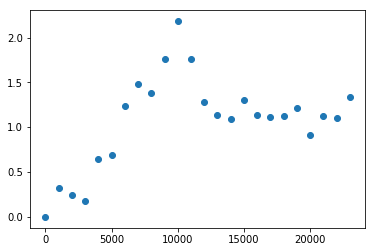

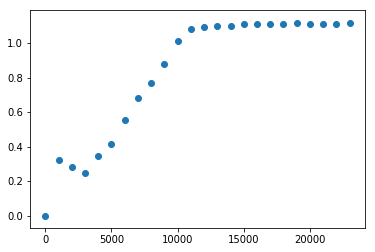

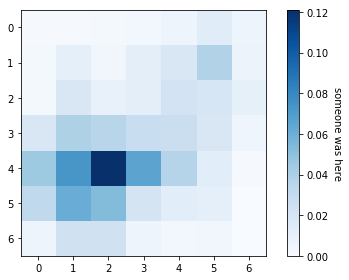

Current Random level is 0.7314732844477848
In Step 24000 the average reward of 1000 is 0.94 
Actions: [206. 189. 214. 205. 186.]


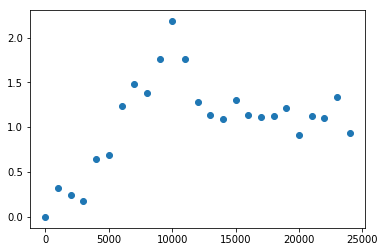

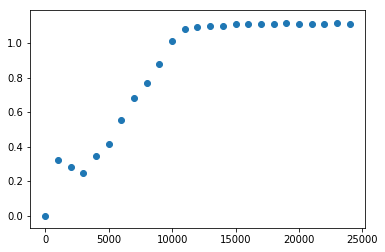

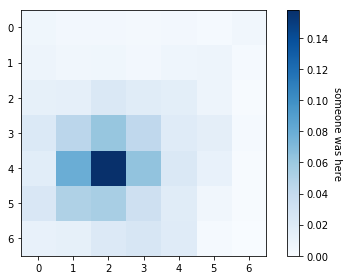

Current Random level is 0.730741811163337
In Step 25000 the average reward of 1000 is 1.12 
Actions: [220. 179. 225. 199. 177.]


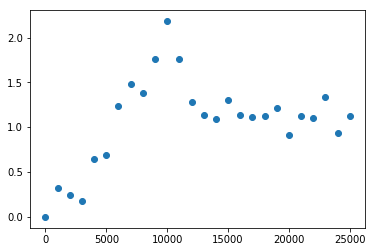

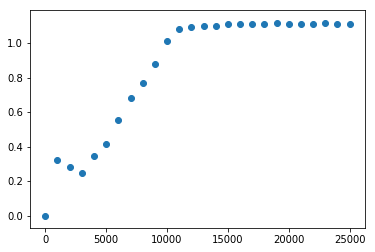

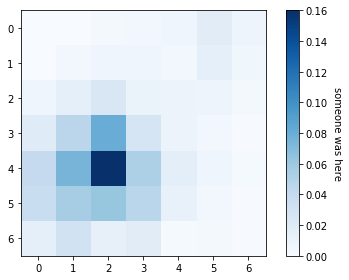

Current Random level is 0.7300110693521737
In Step 26000 the average reward of 1000 is 1.51 
Actions: [198. 166. 202. 173. 261.]


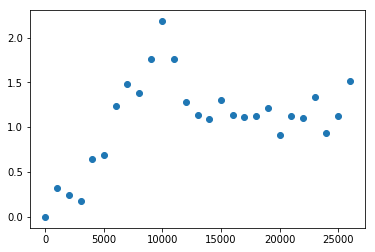

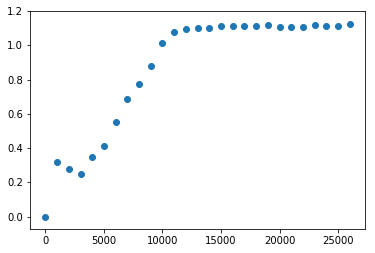

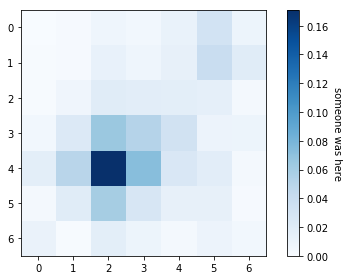

Current Random level is 0.7292810582828215
In Step 27000 the average reward of 1000 is 0.99 
Actions: [217. 179. 226. 205. 173.]


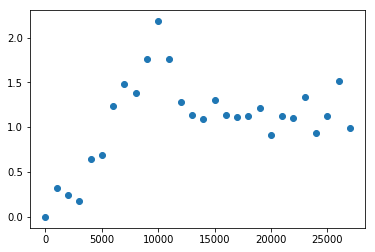

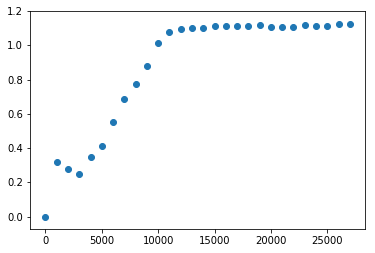

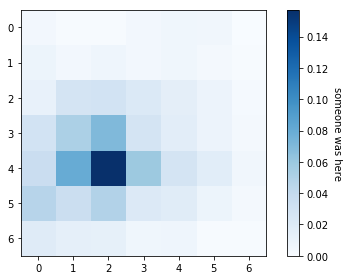

Current Random level is 0.7285517772245387
In Step 28000 the average reward of 1000 is 1.09 
Actions: [210. 184. 219. 194. 193.]


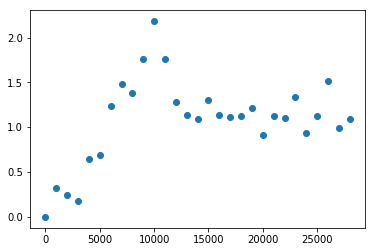

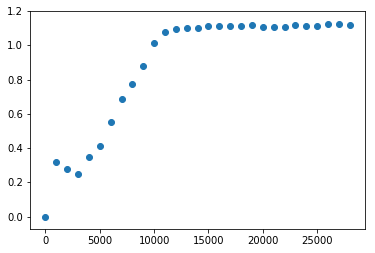

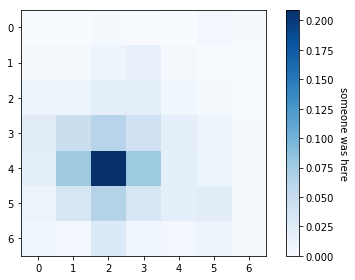

Current Random level is 0.7278232254473141
In Step 29000 the average reward of 1000 is 0.99 
Actions: [218. 167. 226. 179. 210.]


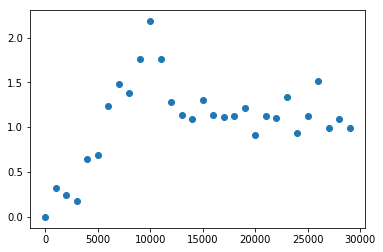

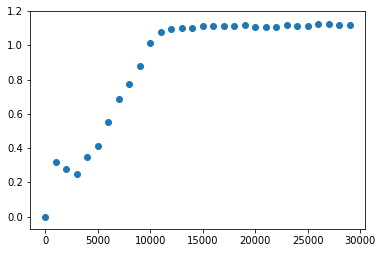

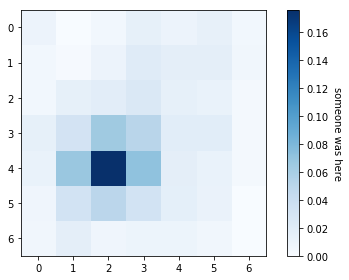

Current Random level is 0.7270954022218669
In Step 30000 the average reward of 1000 is 1.05 
Actions: [191. 191. 204. 202. 212.]


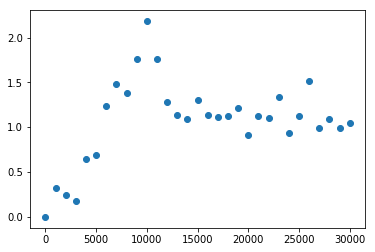

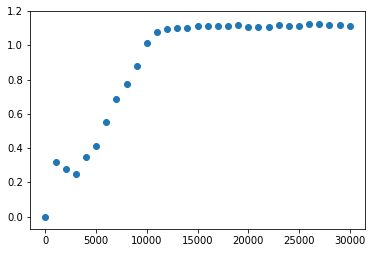

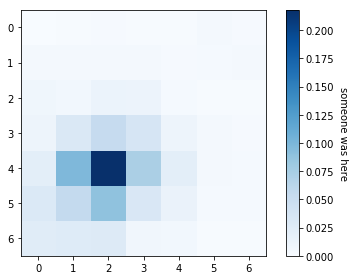

Current Random level is 0.726368306819645
In Step 31000 the average reward of 1000 is 1.06 
Actions: [211. 186. 216. 195. 192.]


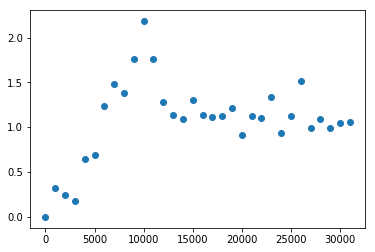

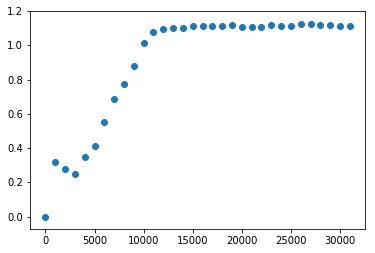

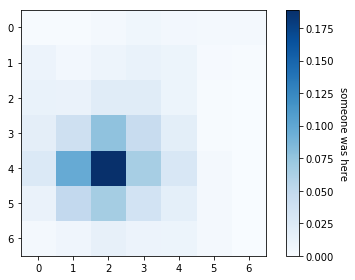

Current Random level is 0.7256419385128254
In Step 32000 the average reward of 1000 is 1.2 
Actions: [205. 177. 219. 186. 213.]


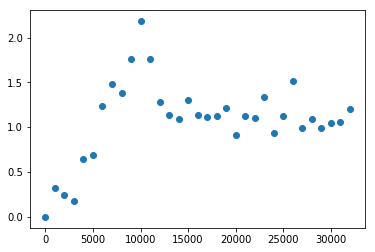

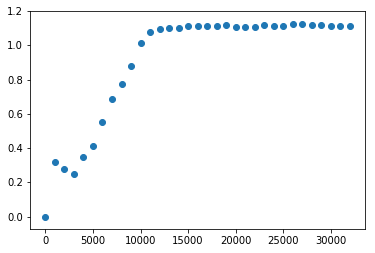

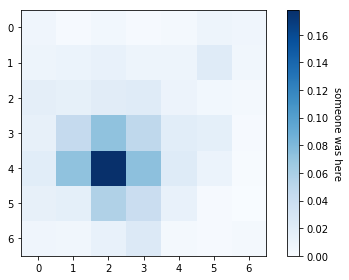

Current Random level is 0.7249162965743126
In Step 33000 the average reward of 1000 is 1.15 
Actions: [186. 181. 192. 206. 235.]


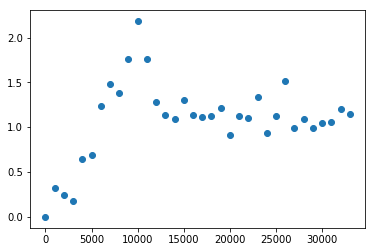

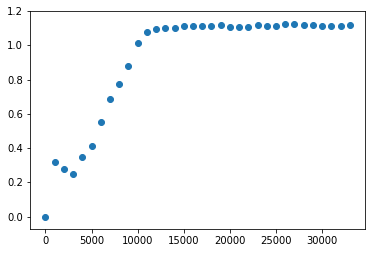

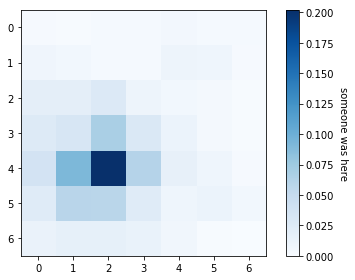

Current Random level is 0.7241913802777382
In Step 34000 the average reward of 1000 is 1.21 
Actions: [213. 169. 226. 189. 203.]


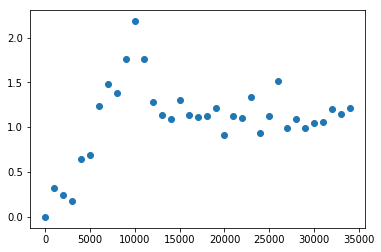

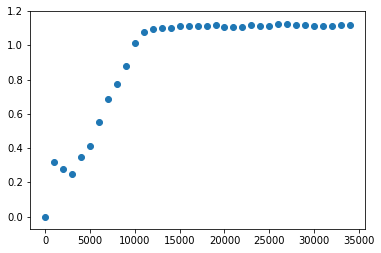

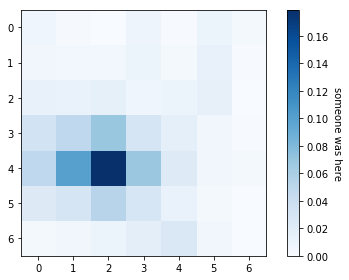

Current Random level is 0.7234671888974605
In Step 35000 the average reward of 1000 is 0.98 
Actions: [207. 172. 219. 189. 213.]


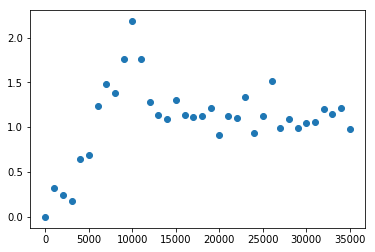

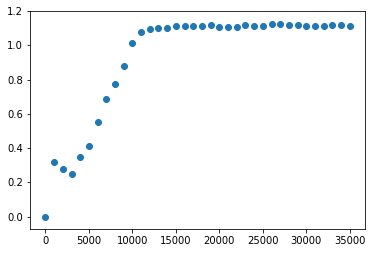

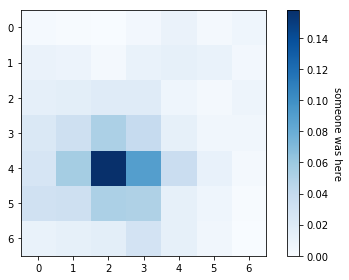

Current Random level is 0.722743721708563
In Step 36000 the average reward of 1000 is 1.52 
Actions: [204. 151. 208. 163. 274.]


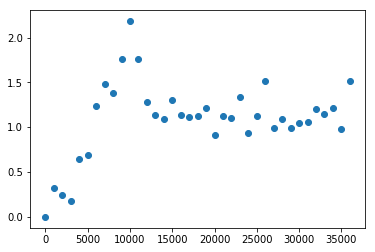

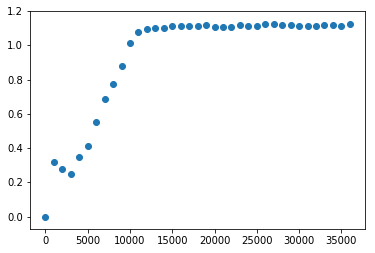

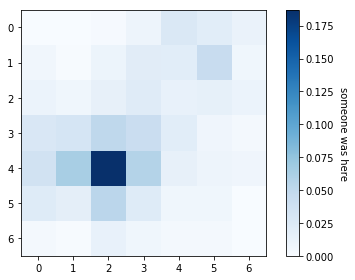

Current Random level is 0.7220209779868545
In Step 37000 the average reward of 1000 is 1.09 
Actions: [202. 173. 211. 197. 217.]


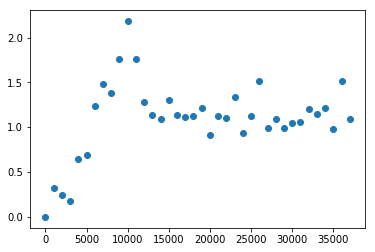

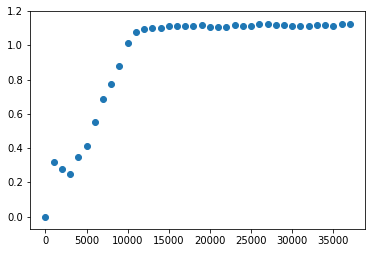

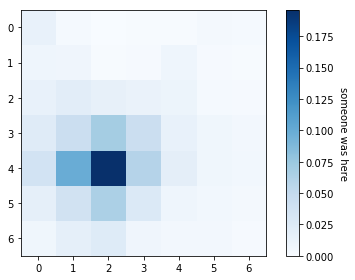

Current Random level is 0.7212989570088676
In Step 38000 the average reward of 1000 is 1.38 
Actions: [214. 176. 224. 179. 207.]


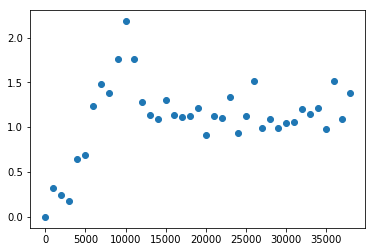

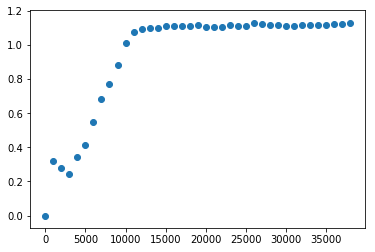

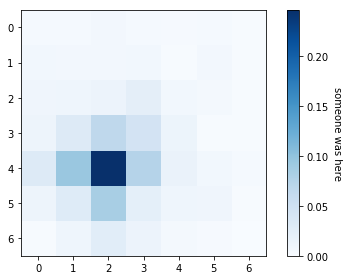

Current Random level is 0.7205776580518587
In Step 39000 the average reward of 1000 is 1.18 
Actions: [197. 181. 205. 199. 218.]


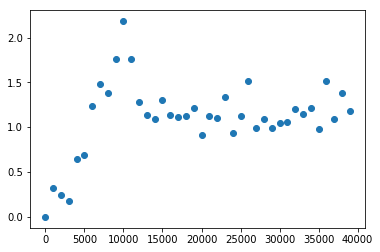

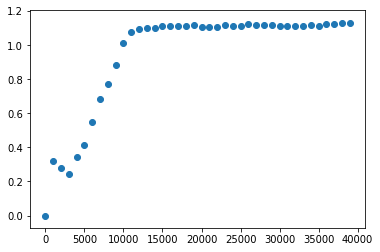

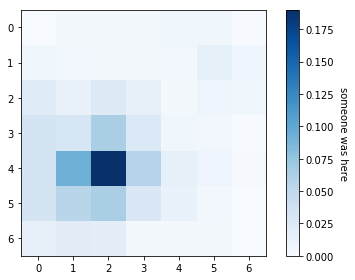

Current Random level is 0.7198570803938068
In Step 40000 the average reward of 1000 is 1.17 
Actions: [194. 189. 206. 200. 211.]


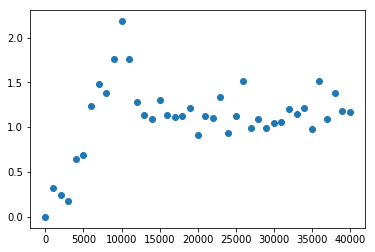

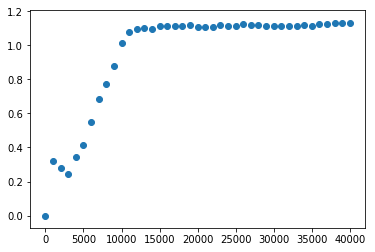

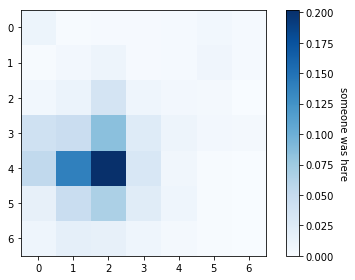

Current Random level is 0.719137223313413
In Step 41000 the average reward of 1000 is 1.11 
Actions: [203. 181. 211. 201. 204.]


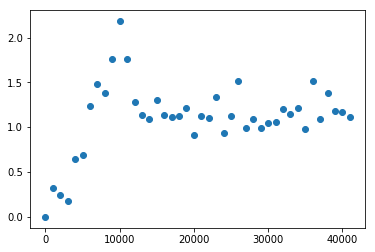

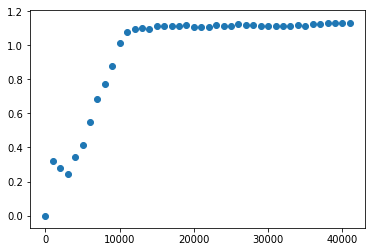

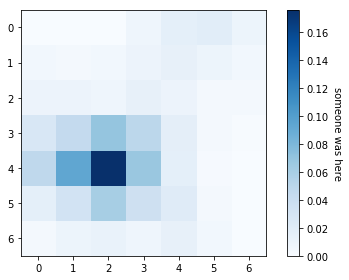

Current Random level is 0.7184180860900996
In Step 42000 the average reward of 1000 is 1.17 
Actions: [181. 191. 189. 193. 246.]


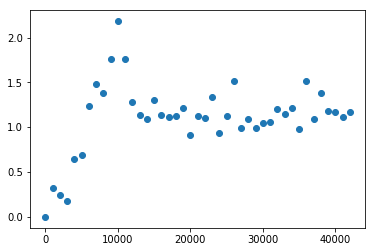

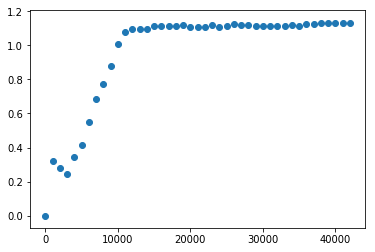

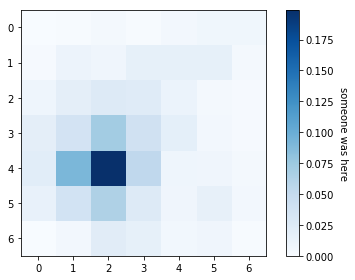

Current Random level is 0.7176996680040095
In Step 43000 the average reward of 1000 is 1.29 
Actions: [194. 178. 207. 197. 224.]


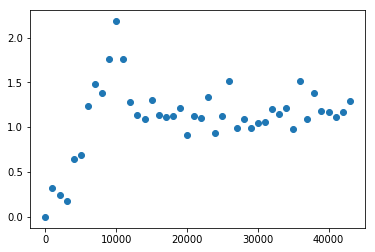

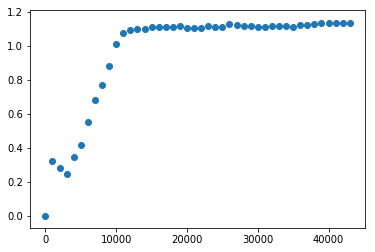

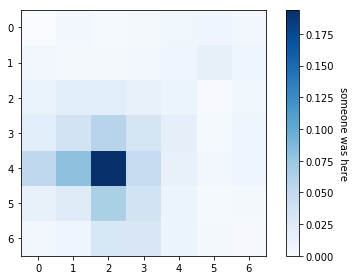

Current Random level is 0.7169819683360055
In Step 44000 the average reward of 1000 is 1.01 
Actions: [202. 195. 215. 206. 182.]


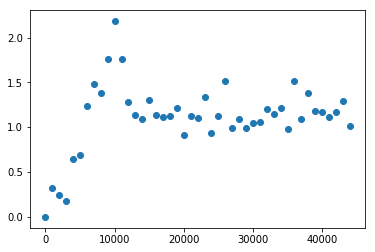

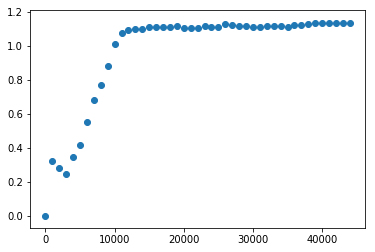

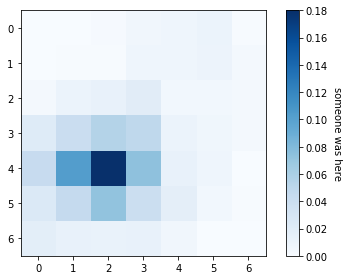

Current Random level is 0.7162649863676694
In Step 45000 the average reward of 1000 is 1.26 
Actions: [209. 184. 212. 194. 201.]


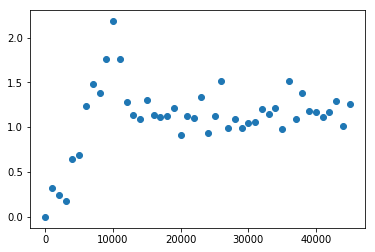

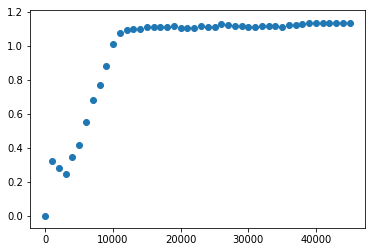

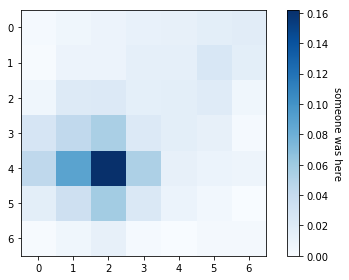

Current Random level is 0.7155487213813018
In Step 46000 the average reward of 1000 is 1.4 
Actions: [199. 165. 204. 178. 254.]


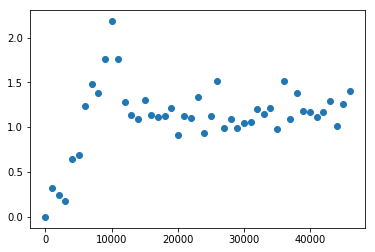

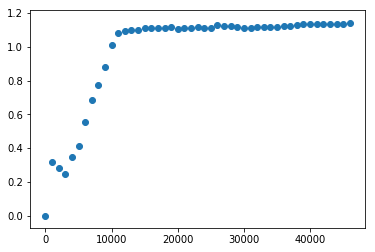

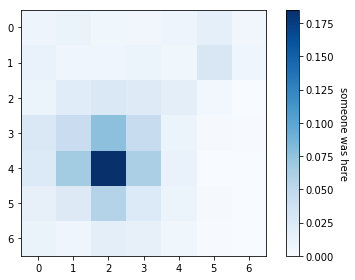

Current Random level is 0.7148331726599204
In Step 47000 the average reward of 1000 is 1.21 
Actions: [219. 183. 232. 191. 175.]


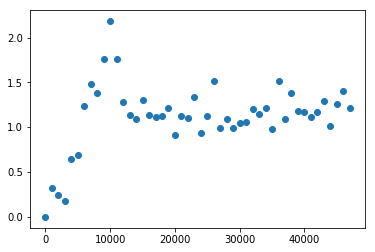

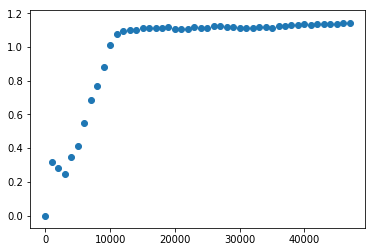

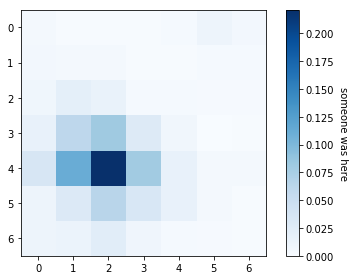

Current Random level is 0.7141183394872604
In Step 48000 the average reward of 1000 is 0.8 
Actions: [230. 172. 244. 197. 157.]


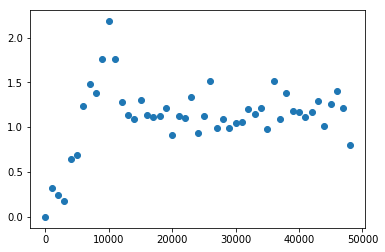

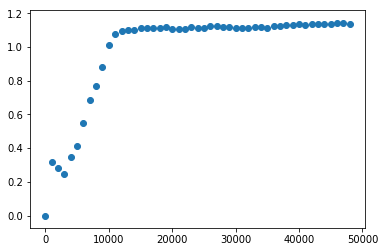

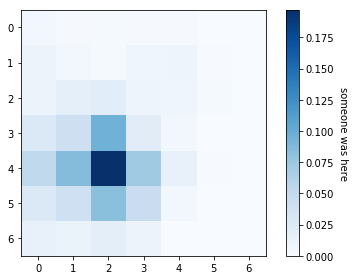

Current Random level is 0.7134042211477731
In Step 49000 the average reward of 1000 is 1.62 
Actions: [157. 190. 168. 188. 297.]


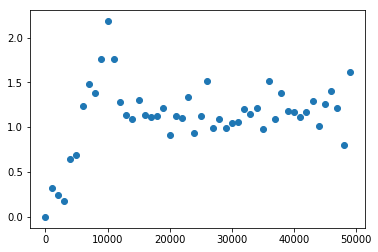

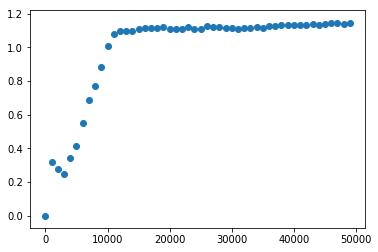

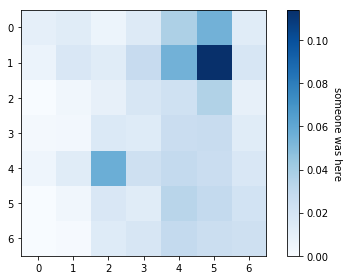

Current Random level is 0.7126908169266254
In Step 50000 the average reward of 1000 is 1.75 
Actions: [179. 163. 193. 195. 270.]


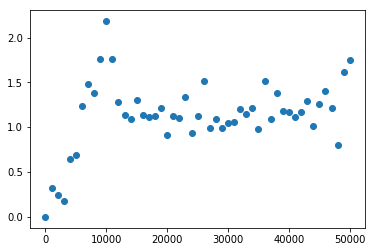

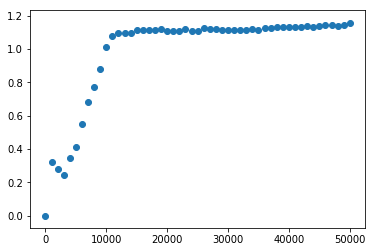

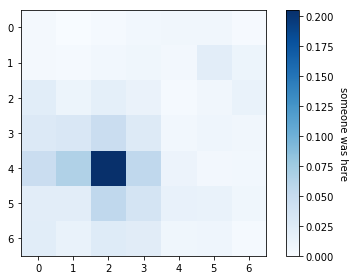

Current Random level is 0.7119781261096988
In Step 51000 the average reward of 1000 is 1.66 
Actions: [191. 185. 200. 203. 221.]


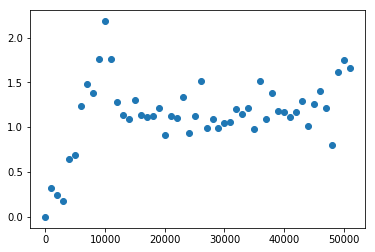

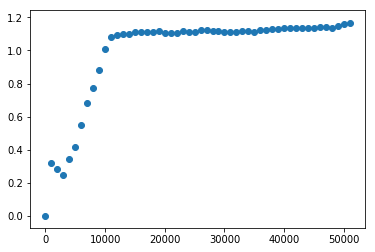

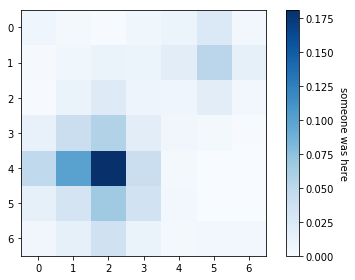

Current Random level is 0.7112661479835891
In Step 52000 the average reward of 1000 is 1.97 
Actions: [206. 184. 210. 194. 206.]


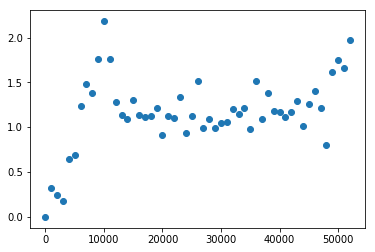

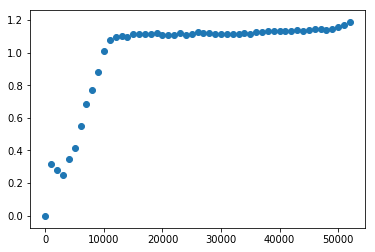

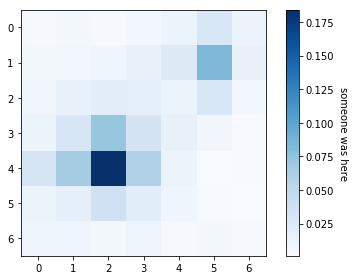

Current Random level is 0.7105548818356056
In Step 53000 the average reward of 1000 is 1.33 
Actions: [216. 188. 231. 194. 171.]


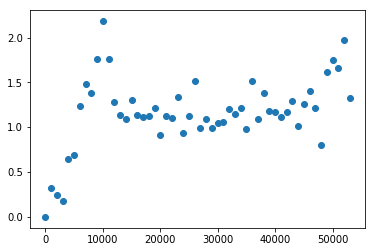

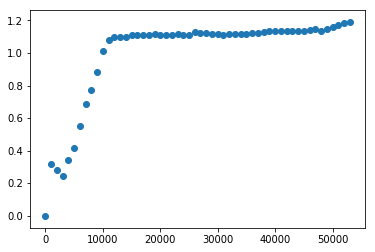

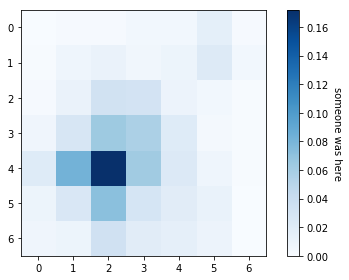

Current Random level is 0.70984432695377
In Step 54000 the average reward of 1000 is 1.65 
Actions: [210. 179. 220. 197. 194.]


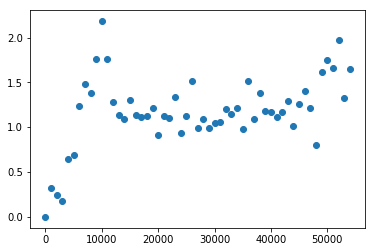

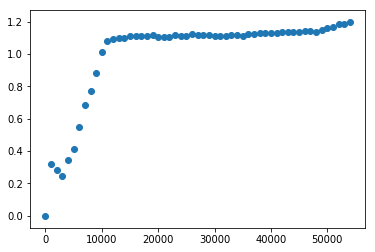

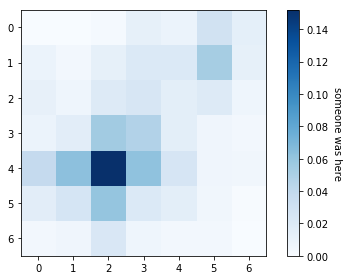

Current Random level is 0.7091344826268162
In Step 55000 the average reward of 1000 is 1.47 
Actions: [203. 200. 219. 221. 157.]


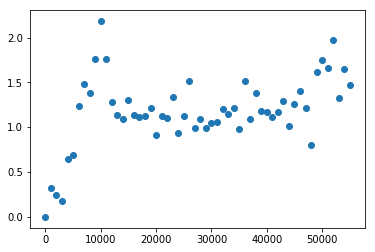

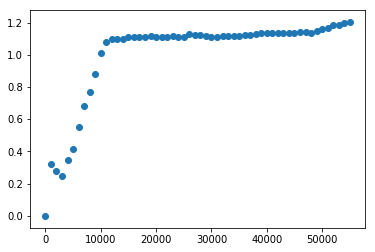

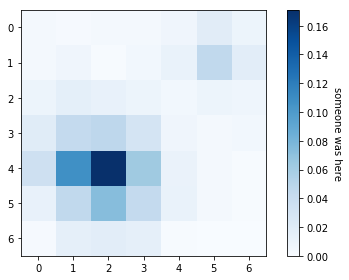

Current Random level is 0.7084253481441894
In Step 56000 the average reward of 1000 is 1.3 
Actions: [191. 190. 207. 202. 210.]


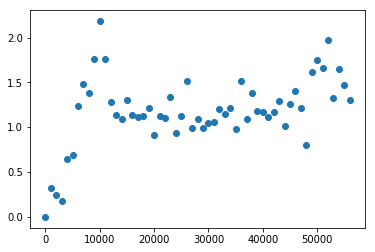

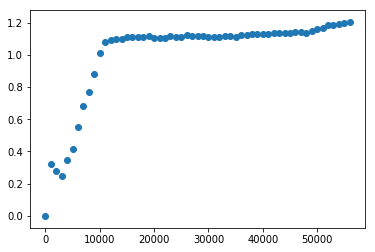

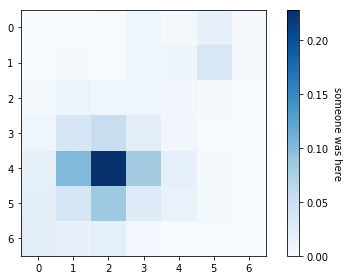

Current Random level is 0.7077169227960453
In Step 57000 the average reward of 1000 is 1.4 
Actions: [193. 187. 200. 202. 218.]


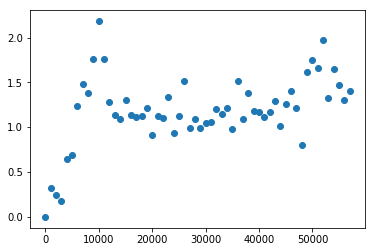

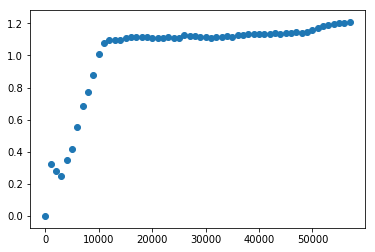

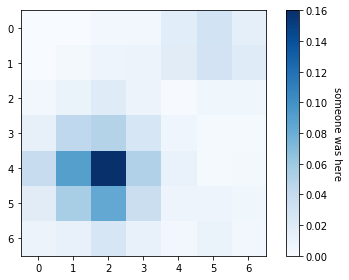

Current Random level is 0.7070092058732492
In Step 58000 the average reward of 1000 is 1.28 
Actions: [208. 184. 215. 197. 196.]


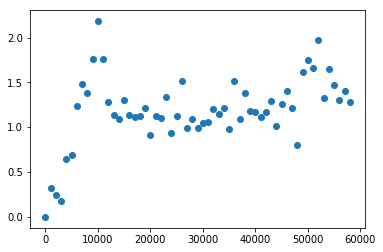

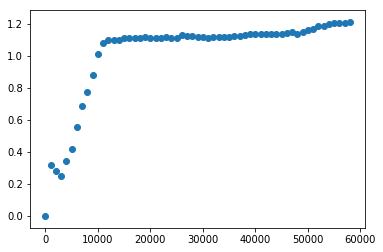

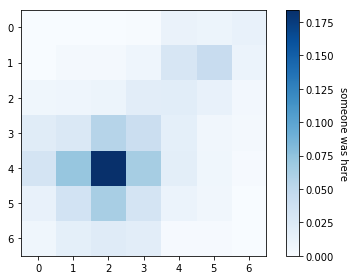

Current Random level is 0.7063021966673759
In Step 59000 the average reward of 1000 is 1.98 
Actions: [208. 170. 224. 181. 217.]


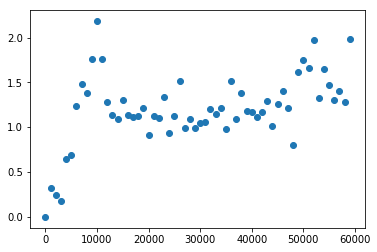

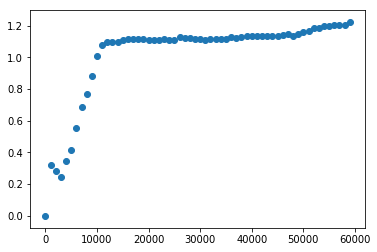

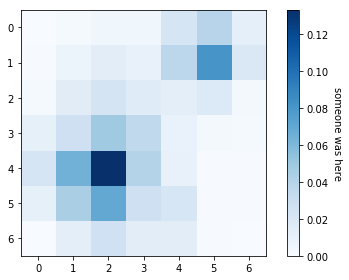

Current Random level is 0.7055958944707086
In Step 60000 the average reward of 1000 is 1.25 
Actions: [212. 176. 216. 191. 205.]


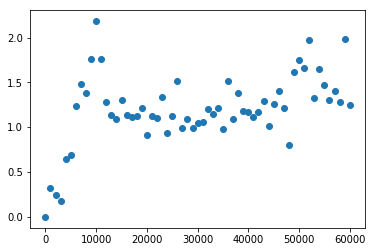

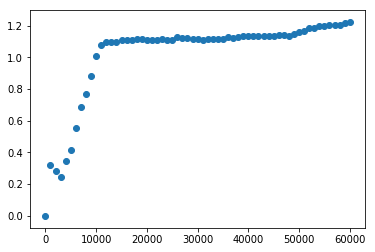

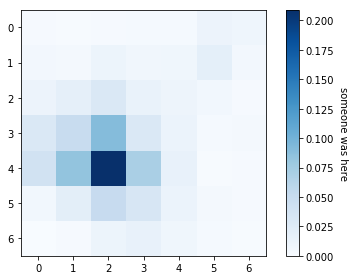

Current Random level is 0.7048902985762379
In Step 61000 the average reward of 1000 is 1.12 
Actions: [190. 201. 206. 213. 190.]


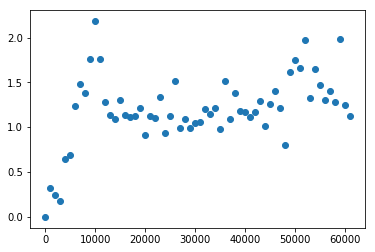

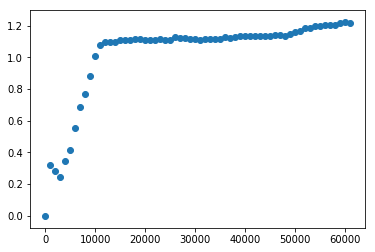

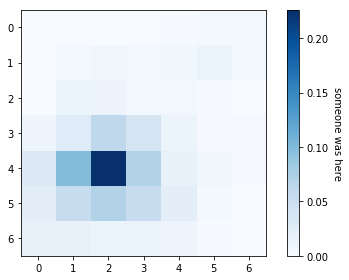

Current Random level is 0.7041854082776616
In Step 62000 the average reward of 1000 is 1.39 
Actions: [224. 164. 226. 174. 212.]


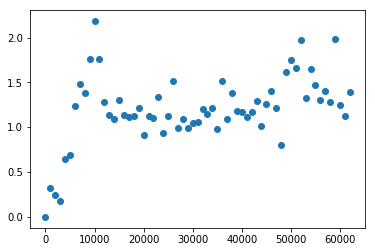

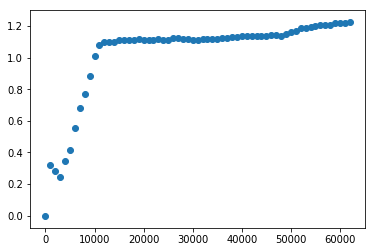

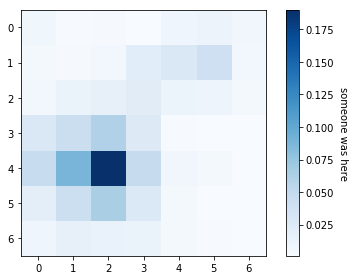

Current Random level is 0.703481222869384
In Step 63000 the average reward of 1000 is 1.35 
Actions: [212. 177. 221. 202. 188.]


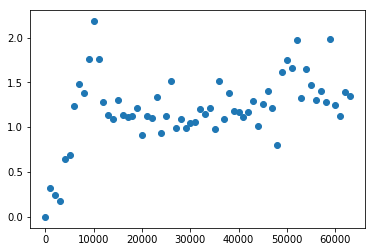

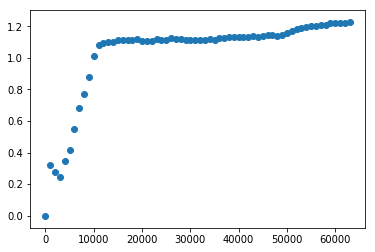

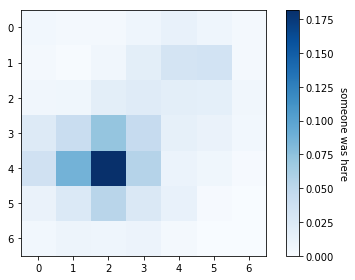

Current Random level is 0.7027777416465146
In Step 64000 the average reward of 1000 is 1.0 
Actions: [222. 179. 230. 184. 185.]


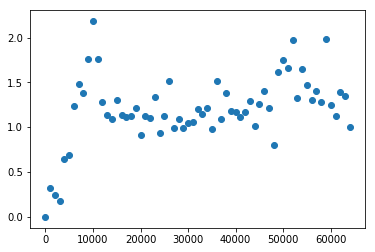

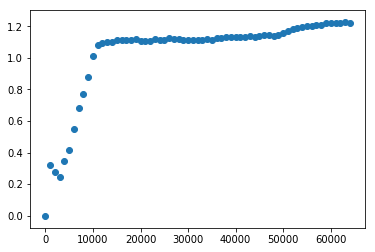

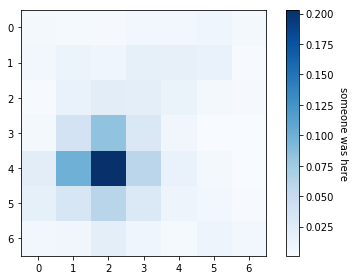

Current Random level is 0.7020749639048681
In Step 65000 the average reward of 1000 is 1.16 
Actions: [203. 172. 207. 189. 229.]


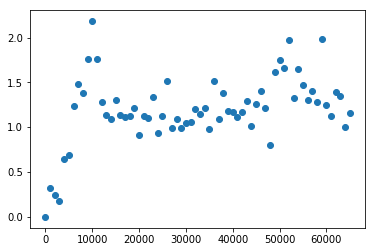

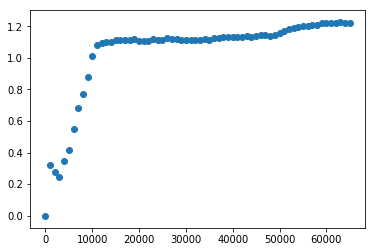

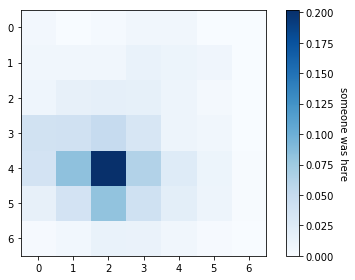

Current Random level is 0.7013728889409633
In Step 66000 the average reward of 1000 is 1.25 
Actions: [202. 180. 209. 188. 221.]


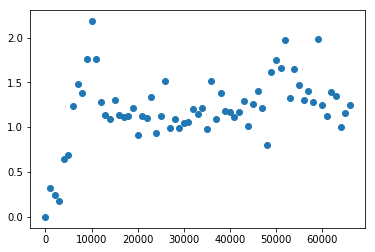

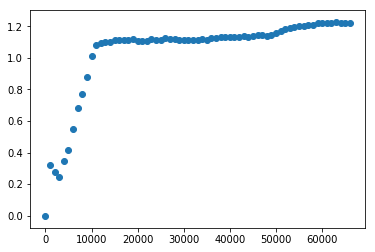

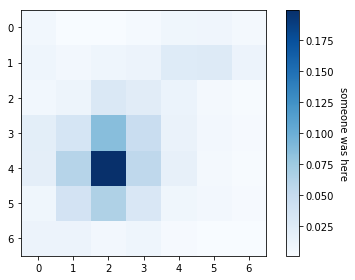

Current Random level is 0.7006715160520223
In Step 67000 the average reward of 1000 is 1.99 
Actions: [173. 180. 180. 183. 284.]


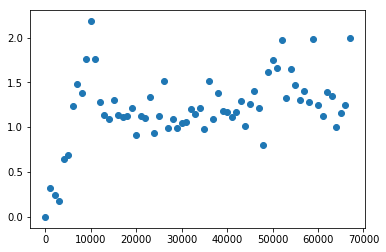

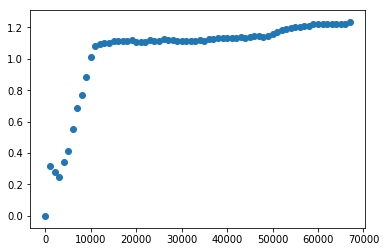

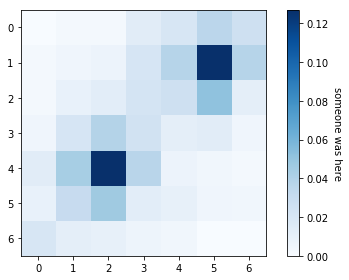

Current Random level is 0.6999708445359702
In Step 68000 the average reward of 1000 is 1.49 
Actions: [188. 177. 208. 214. 213.]


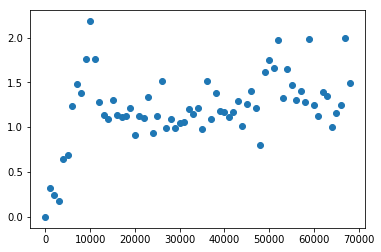

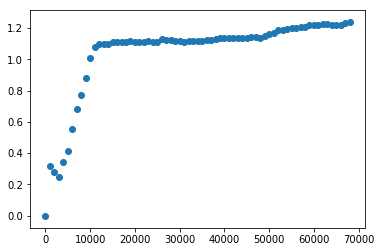

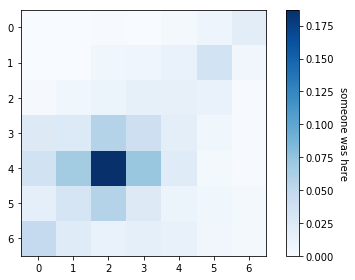

Current Random level is 0.6992708736914343
In Step 69000 the average reward of 1000 is 2.04 
Actions: [193. 172. 202. 184. 249.]


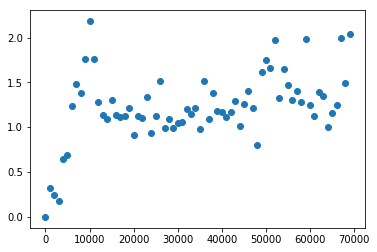

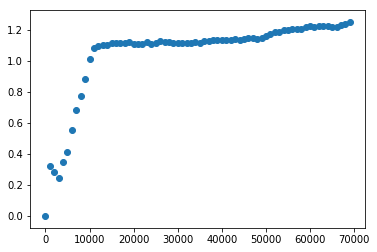

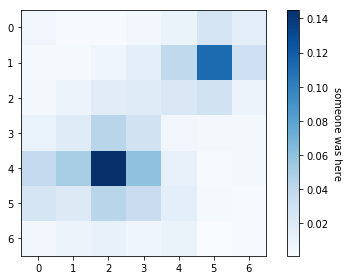

Current Random level is 0.6985716028177428
In Step 70000 the average reward of 1000 is 2.0 
Actions: [174. 181. 193. 226. 226.]


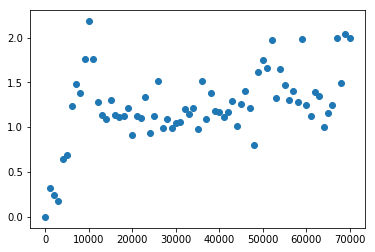

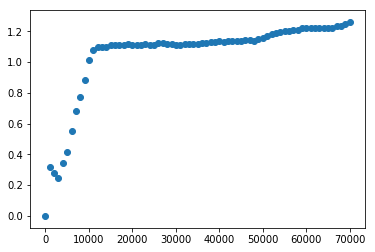

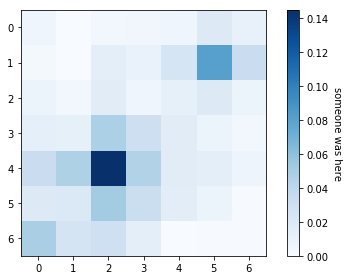

Current Random level is 0.697873031214925
In Step 71000 the average reward of 1000 is 1.47 
Actions: [172. 181. 207. 213. 227.]


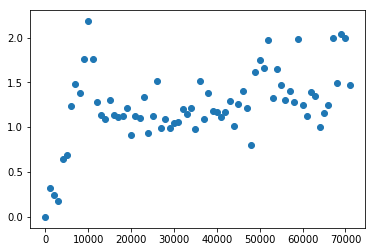

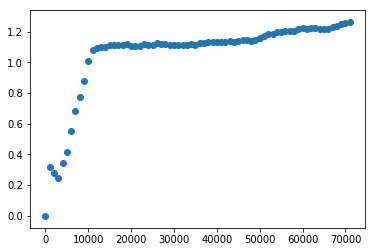

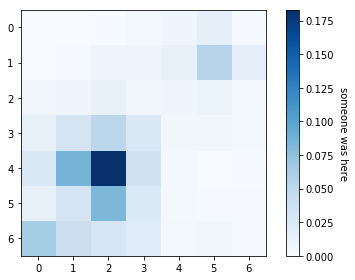

Current Random level is 0.6971751581837101
In Step 72000 the average reward of 1000 is 1.92 
Actions: [202. 180. 217. 212. 189.]


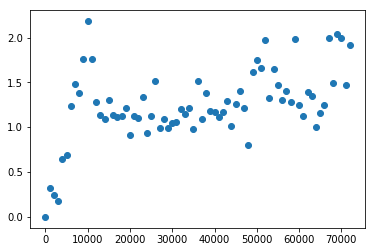

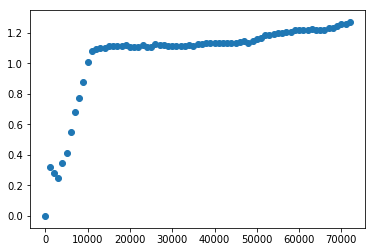

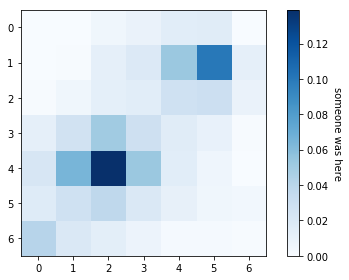

Current Random level is 0.6964779830255264
In Step 73000 the average reward of 1000 is 2.01 
Actions: [212. 154. 214. 178. 242.]


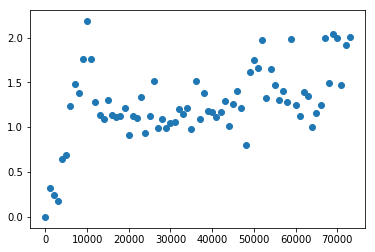

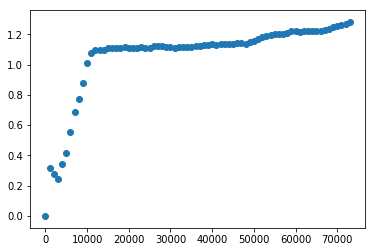

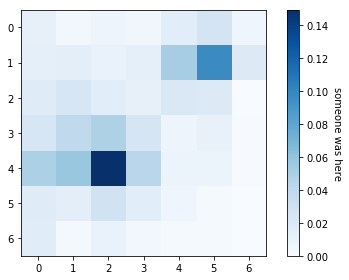

Current Random level is 0.6957815050425009
In Step 74000 the average reward of 1000 is 2.14 
Actions: [181. 172. 214. 193. 240.]


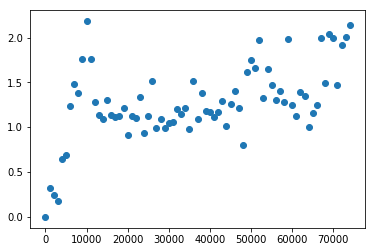

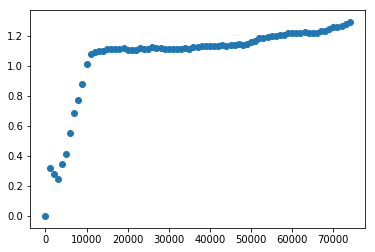

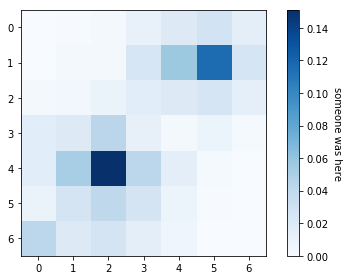

Current Random level is 0.6950857235374585
In Step 75000 the average reward of 1000 is 2.21 
Actions: [179. 187. 189. 230. 215.]


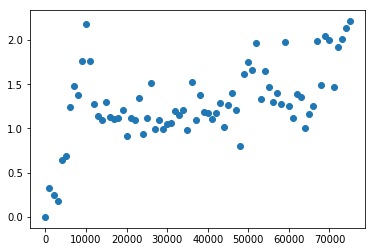

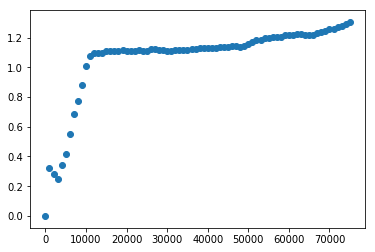

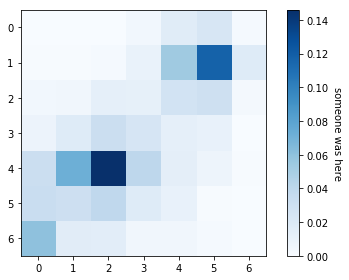

Current Random level is 0.694390637813921
In Step 76000 the average reward of 1000 is 2.14 
Actions: [177. 185. 200. 216. 222.]


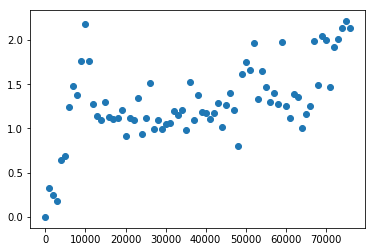

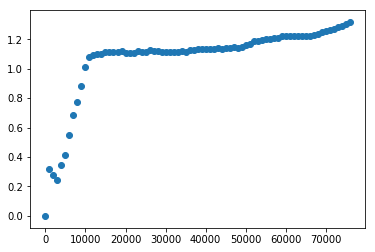

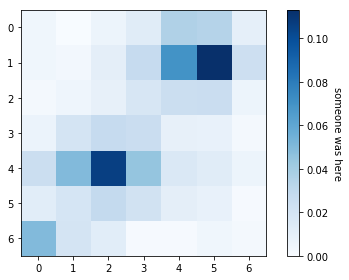

Current Random level is 0.693696247176107
In Step 77000 the average reward of 1000 is 2.4 
Actions: [184. 187. 205. 205. 219.]


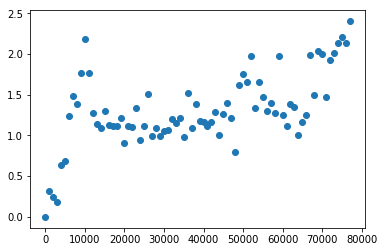

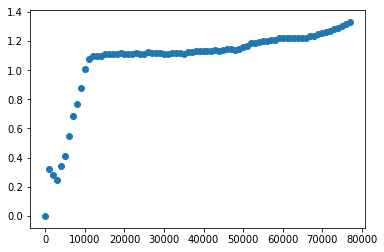

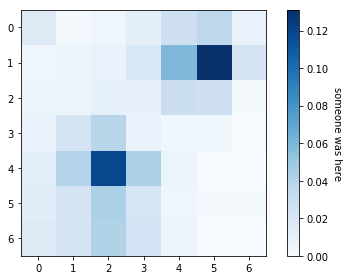

Current Random level is 0.6930025509289309
In Step 78000 the average reward of 1000 is 1.8 
Actions: [204. 171. 220. 189. 216.]


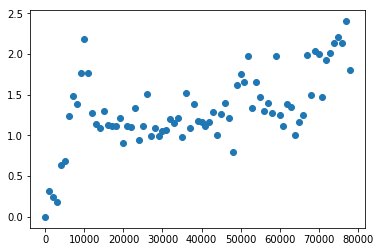

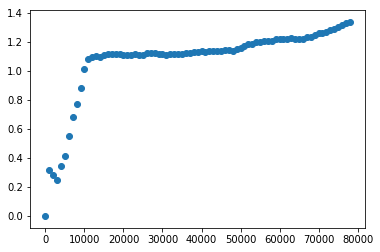

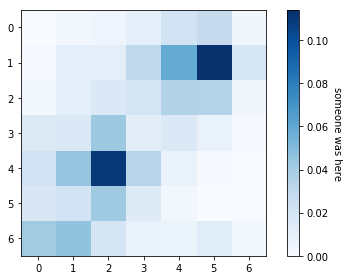

Current Random level is 0.692309548378002
In Step 79000 the average reward of 1000 is 2.32 
Actions: [177. 192. 180. 223. 228.]


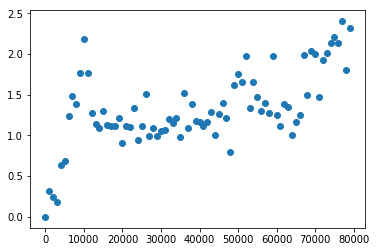

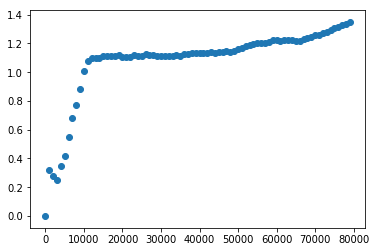

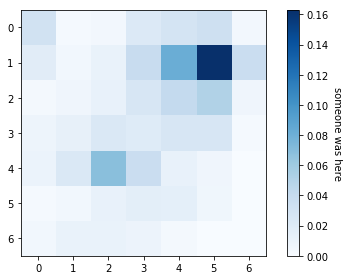

Current Random level is 0.691617238829624
In Step 80000 the average reward of 1000 is 2.66 
Actions: [183. 192. 186. 191. 248.]


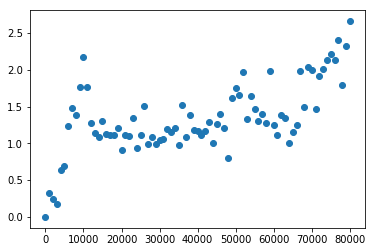

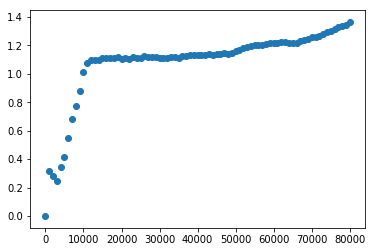

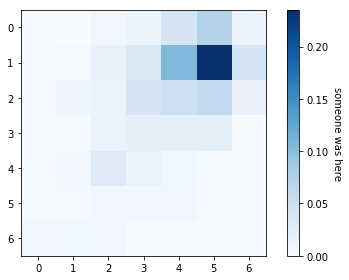

Current Random level is 0.6909256215907944
In Step 81000 the average reward of 1000 is 2.74 
Actions: [150. 177. 170. 217. 286.]


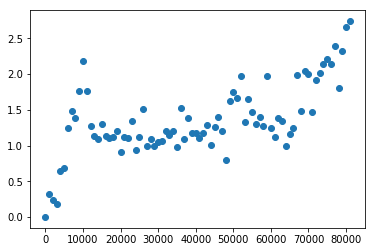

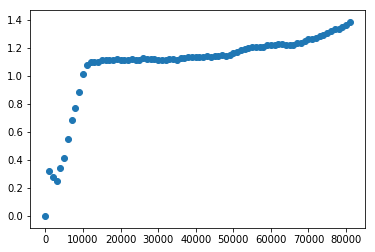

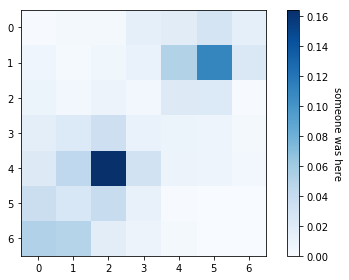

Current Random level is 0.6902346959692036
In Step 82000 the average reward of 1000 is 1.4 
Actions: [164. 181. 194. 216. 245.]


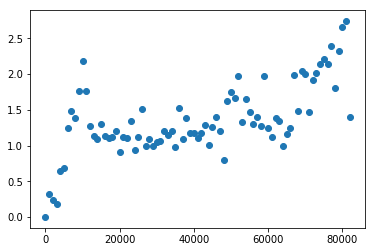

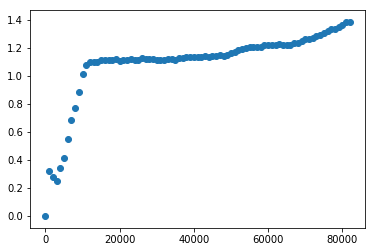

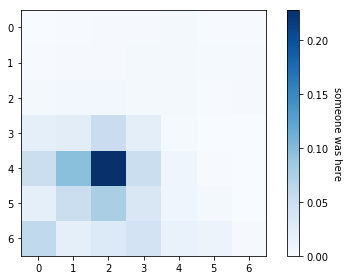

Current Random level is 0.6895444612732344
In Step 83000 the average reward of 1000 is 1.38 
Actions: [192. 198. 210. 216. 184.]


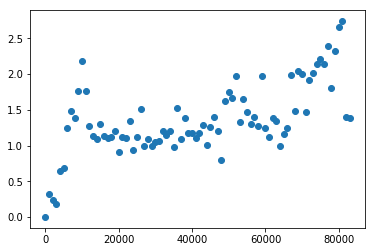

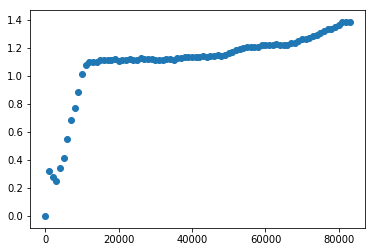

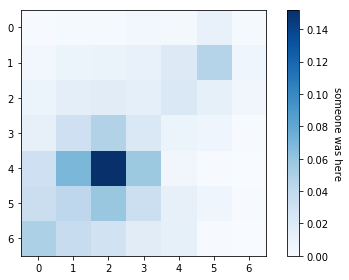

Current Random level is 0.6888549168119612
In Step 84000 the average reward of 1000 is 2.04 
Actions: [171. 184. 198. 208. 239.]


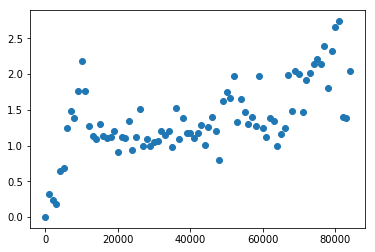

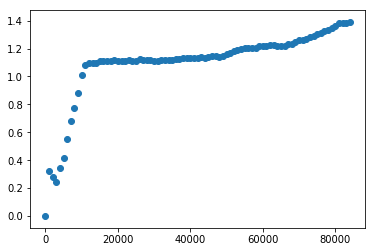

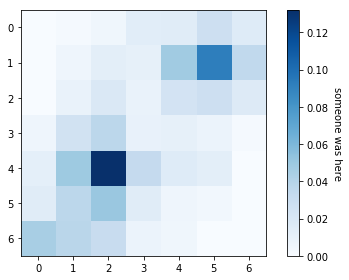

Current Random level is 0.6881660618951493
In Step 85000 the average reward of 1000 is 2.33 
Actions: [173. 188. 183. 213. 243.]


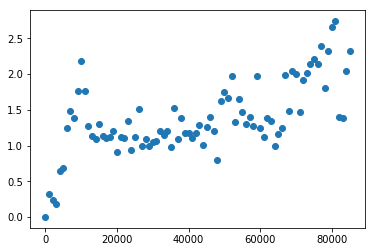

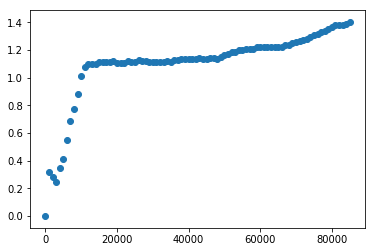

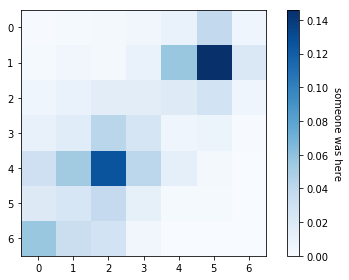

Current Random level is 0.6874778958332541
In Step 86000 the average reward of 1000 is 2.47 
Actions: [202. 167. 212. 179. 240.]


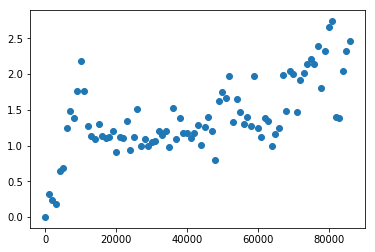

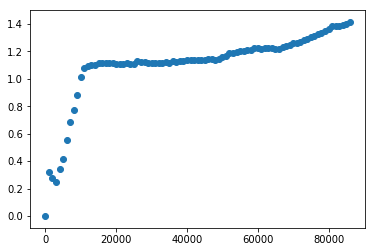

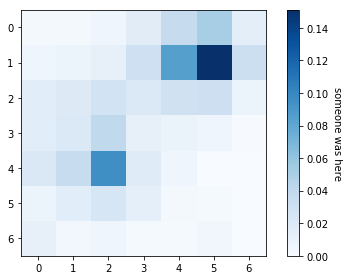

Current Random level is 0.6867904179374209
In Step 87000 the average reward of 1000 is 2.2 
Actions: [195. 160. 222. 178. 245.]


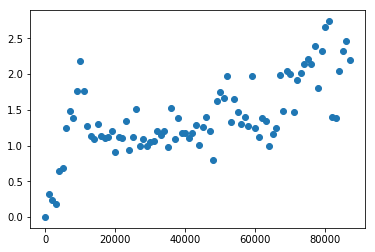

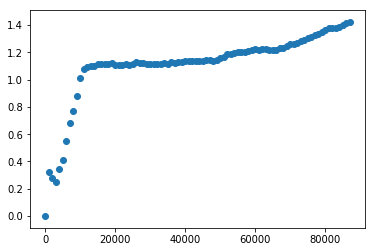

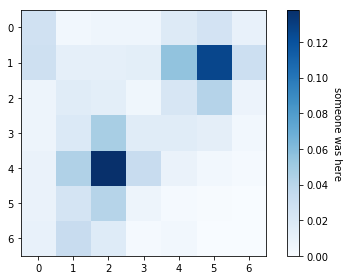

Current Random level is 0.6861036275194835
In Step 88000 the average reward of 1000 is 2.82 
Actions: [197. 170. 194. 184. 255.]


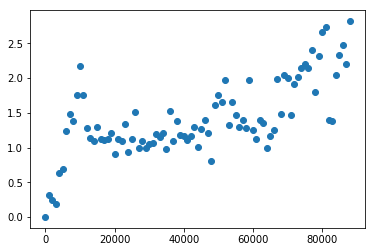

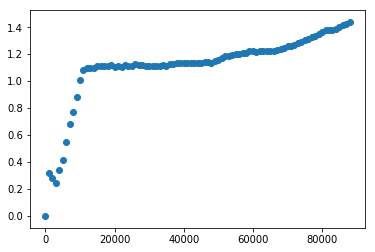

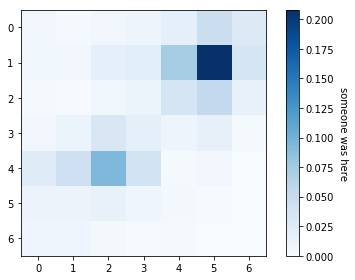

Current Random level is 0.685417523891964
In Step 89000 the average reward of 1000 is 2.55 
Actions: [173. 189. 201. 229. 208.]


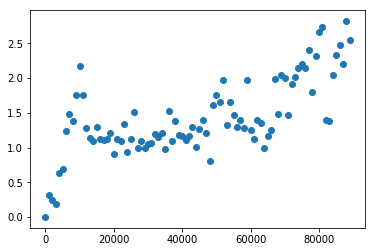

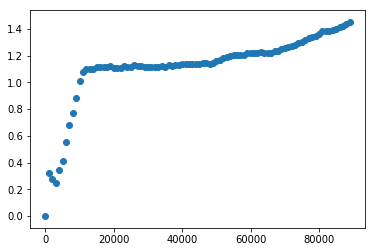

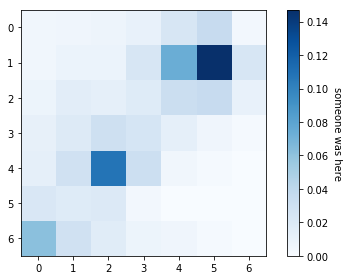

Current Random level is 0.684732106368072
In Step 90000 the average reward of 1000 is 2.83 
Actions: [173. 188. 181. 196. 262.]


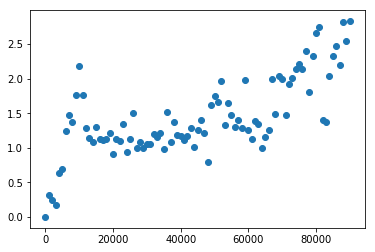

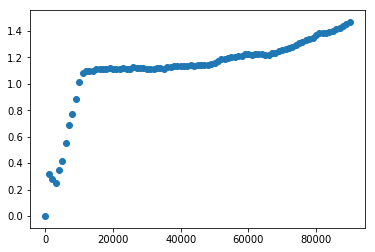

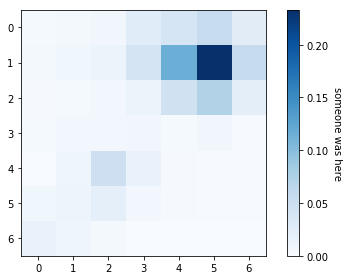

Current Random level is 0.6840473742617039
In Step 91000 the average reward of 1000 is 2.74 
Actions: [170. 198. 179. 213. 240.]


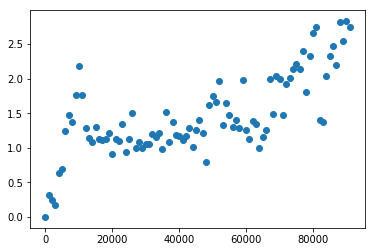

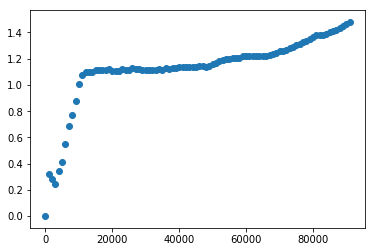

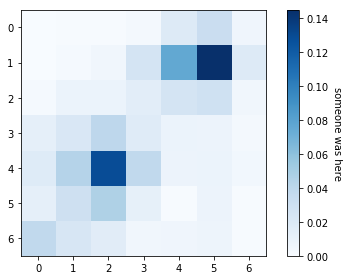

Current Random level is 0.6833633268874422
In Step 92000 the average reward of 1000 is 2.98 
Actions: [184. 171. 207. 183. 255.]


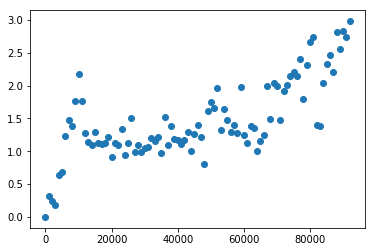

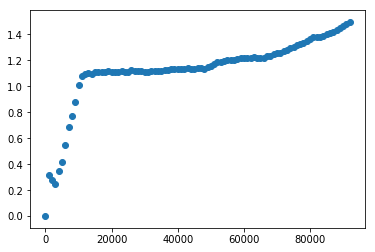

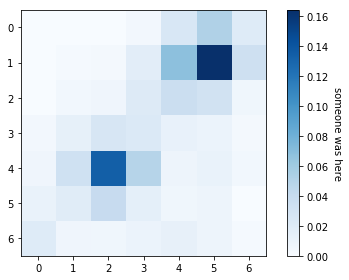

Current Random level is 0.6826799635605547
In Step 93000 the average reward of 1000 is 1.58 
Actions: [180. 200. 207. 224. 189.]


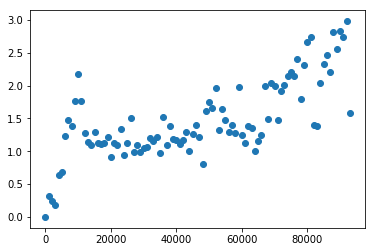

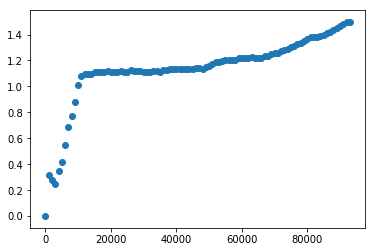

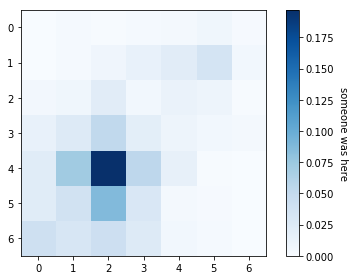

Current Random level is 0.6819972835969942
In Step 94000 the average reward of 1000 is 2.29 
Actions: [185. 162. 186. 177. 290.]


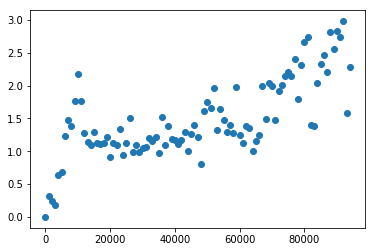

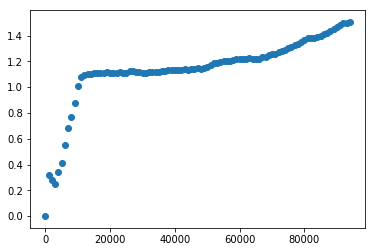

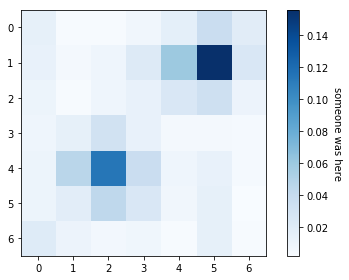

Current Random level is 0.6813152863133972
In Step 95000 the average reward of 1000 is 1.87 
Actions: [177. 188. 201. 216. 218.]


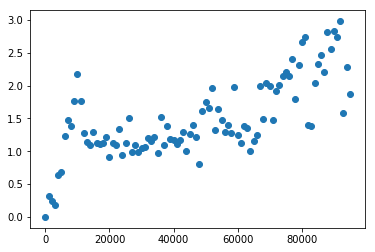

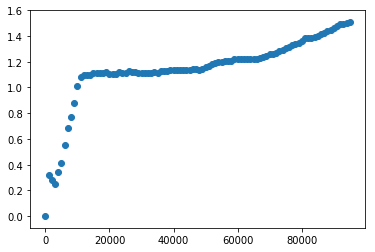

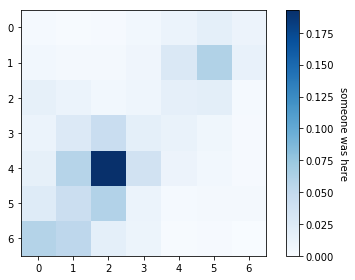

Current Random level is 0.6806339710270838
In Step 96000 the average reward of 1000 is 2.74 
Actions: [171. 192. 179. 212. 246.]


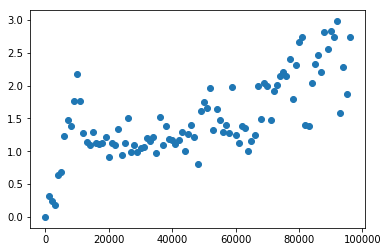

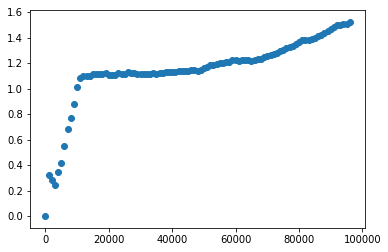

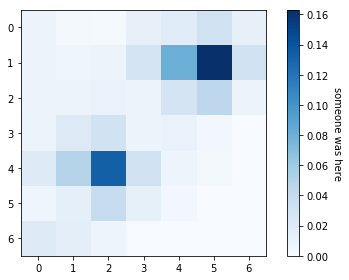

Current Random level is 0.6799533370560567
In Step 97000 the average reward of 1000 is 1.89 
Actions: [187. 184. 205. 205. 219.]


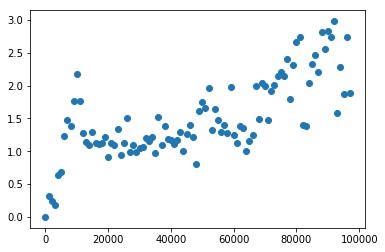

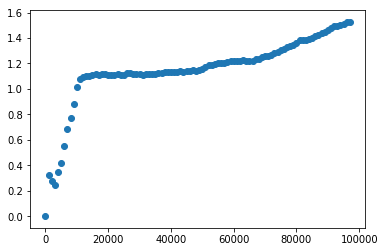

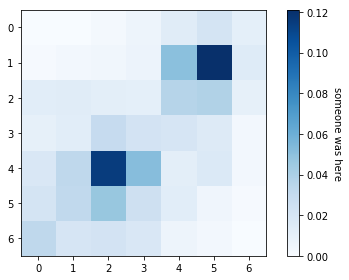

Current Random level is 0.6792733837190006
In Step 98000 the average reward of 1000 is 2.61 
Actions: [168. 181. 181. 211. 259.]


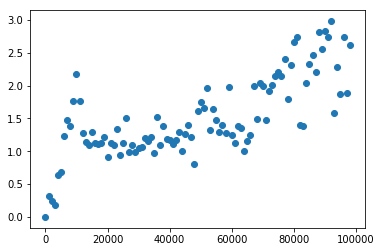

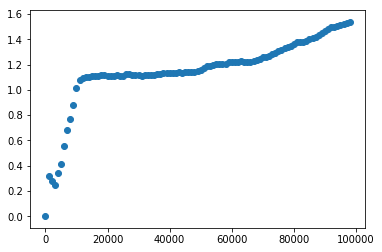

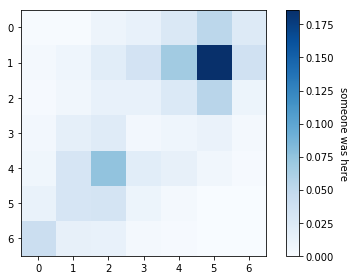

Current Random level is 0.6785941103352816
In Step 99000 the average reward of 1000 is 3.05 
Actions: [158. 192. 160. 207. 283.]


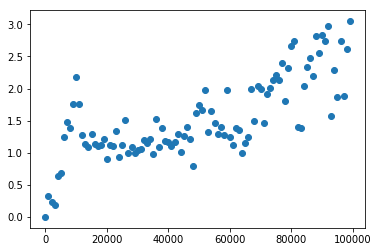

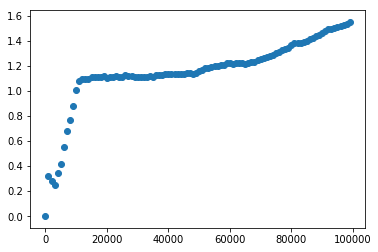

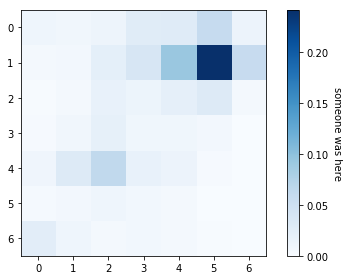

In [28]:
importlib.reload(E)
importlib.reload(H)

for i in range(n_episodes):
    env = E.Environment(dim = (grid_size_h,grid_size_w),reward_eat_trash=10, 
                        reward_invalid_move=0, reward_nothing_happend=0, 
                        trash_appearence_prob=0.1, number_trash_sources=0, saved_timesteps=time_steps )
    env.trash_sources.append(trash_source_1)
    env.trash_sources.append(trash_source_2)
    _, _,  _, _, trash_sources = env.debug_data_export()
    for idx,trash_source in enumerate(trash_sources): 
        print("Trash Source {} has its mean at {}".format(idx, trash_source.mean))
    d = []
    action_avg = np.zeros((10000,5))
    list_avg_rwd = []
    list_steps = []
    all_time_reward = 0
    all_time_reward_avg_history = []
    all_time_reward_steps_history = []
    for k in range(n_agents):
        env.add_agent(coord=(k,0),capacity=100000)
    
    X = tuple_to_batch(env.export_known_data())
    
    Q_vals = model.predict(X)
    
    if i % 10 == 0:
        print("Episode {} of {}".format(i + 1, n_episodes))

    r_sum = 0
    
    for step in range(n_steps):
        
        mask = valid_move_mask(X)
        if np.random.random() < max(epsilon, 0.01):
            Q_rand = np.random.random(n_agents * n_actions).reshape((n_agents, n_actions))
            actions = np.apply_along_axis(np.argmax, 1, Q_rand * mask).tolist()
        else:
            actions = np.apply_along_axis(np.argmax, 1, Q_vals * mask).tolist()
            
        # new known state and rewards
        X_reward = env.move_agents(actions)
        heatmap.add_map(X_reward[1][-1]) #Get the current position of all agents
        # after all agents move
        X_new = tuple_to_batch(X_reward[:3])
        rewards = X_reward[3]

        all_time_reward += sum(rewards)
        action_avg[step%number_print, : ] = 0
        action_avg[step%number_print,actions[0]]= 1
        d.append(sum(rewards))
        while(len(d)>number_print):
            del(d[0])
        if(step% number_print == 0): 
            mean = sum(d) / number_print
            
            epsilon *= epsilon_decay
            print("Current Random level is {}".format(max(epsilon, 0.01)))
            print("In Step {} the average reward of {} is {} ".format(step, number_print,mean))
            print("Actions: {}".format(np.sum(action_avg, axis = 0)))
            list_avg_rwd.append(mean)
            list_steps.append(step)
            
            plt.scatter(list_steps, list_avg_rwd)
            plt.show()
            
            
            all_time_reward_avg = all_time_reward / (step+1)
            all_time_reward_avg_history.append(all_time_reward_avg)
            all_time_reward_steps_history.append(step)
            plt.scatter(all_time_reward_steps_history, all_time_reward_avg_history)
            plt.show()
            
            
            #Heatmap
            #print(heatmap.get_heatmap())
            heatmap.show_heatmap()
        Q_vals_new = model.predict(X_new)
        
        Q_vals[range(n_agents), actions] = rewards + gamma * np.max(Q_vals_new, axis=1)
        model.fit(X, Q_vals, epochs=1, verbose=0)
        
        Q_vals = Q_vals_new
        X = X_new

### We now define a new environment and see what the pretrained network will do on that

In [ ]:
env2 = E.Environment(dim = (config.grid_size_h,config.grid_size_w),reward_eat_trash=10, 
                        reward_invalid_move=0, reward_nothing_happend=0, 
                        trash_appearence_prob=0.1, number_trash_sources=0, saved_timesteps=config.time_steps )
env2.trash_sources.append(config.trash_source_3)
env2.trash_sources.append(config.trash_source_4)

run(model, env2)
